In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import re
import datetime
#import mylib
#sns.set_style('whitegrid')
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix,precision_score ,accuracy_score, recall_score
from sklearn.metrics import plot_confusion_matrix
from sklearn import svm


In [2]:
df = pd.read_csv('pae_survey_1.0.csv')

# Functions

In [3]:
# SEP utils file

def missing_heat_map(DataFrame):
    
    '''
    
    This function will plot the heatmap to display missing values
    Arguments: 
    DataFrame : takes a dataframe 
    
    Returns:
    A plot of missing values and a list of columns with percentages of missing values
    
    '''
    
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (18, 6))
    sns.heatmap(DataFrame.isnull(), yticklabels=False, ax = ax, cbar=False,\
                cmap='viridis')
    ax.set_title('dataset')
    plt.show()
        
    # Calculate the missing values to get a percentage 

    for i in DataFrame:
        print(i,': %',int((DataFrame[i].isnull().sum()/len(DataFrame[i]))*100),\
            'With {} missing values'.format((DataFrame[i].isnull().sum())))

In [4]:
    
def pie_chart(chart_name,name,column,varibles):
    
    '''

    This function will plot a pie chart
    Arguments:
    Chart_name : Takes string to display as chart title
    name : The file name that will be saved
    column : The column that will be plotted
    varibles : The number of unique values in the column
    
    '''
    
    pie, ax = plt.subplots(figsize=[10,6])
    labels = column.value_counts().keys()
    plt.pie(x=column.value_counts().values, autopct="%.1f%%", explode=[0.05]*int(varibles), labels=labels, pctdistance=0.5)
    plt.title("{}".format(chart_name), fontsize=14);
    #pie.savefig("pics/{}.png".format(name))

In [5]:
def plot_corr(df):
    
    '''

    This function will plot the correlation
    Arguments:
    df: takes a data frame 
 
    Returns:
    a plot of the correlations in the data frame
    
    '''

    plt.figure(figsize=(20,10))
    corr=df.corr()
    #sns.set(font_scale=2.5)
    sns.heatmap(corr,annot=True, vmin=0, vmax=1, cmap = 'gist_heat_r')



In [6]:
def magnify_corr(dataframe):

    '''

    This function will plot the correlation using an interactive plot
    Arguments:
    dataframe: takes a dataframe 
 
    Returns:
    a plot of the correlations in the data frame
    
    '''
    
    cmap=sns.diverging_palette(5, 250, as_cmap=True)
    corr = dataframe.corr()
    
    a = [dict(selector="th",props=[("font-size","7pt")]),
     dict(selector="td",props=[('padding',"0em 0em")]),
     dict(selector="th:hover",props=[("font-size","12pt")]),
     dict(selector="tr:hover td:hover",props=[('max-width','200px'),('font-size','12pt')])]
    
    
    return corr.style.background_gradient(cmap, axis=1)\
        .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
        .set_caption("Hover to magify")\
        .set_precision(2)\
        .set_table_styles(a)



In [7]:
def top_corr_features(target,number,dataframe):
    
    '''

    This function will give you the required number of highest correlated features to a target 
    Arguments:
    target: column name in string format of the targeted column
    number: The number of highest correlated features required
    data frame: the data frame name without parenthesis 

    returns: A list of the highest correlated features with the target (will also print the list)

    '''

    best_feature_corr=dataframe.corr()[str(target)].sort_values(ascending=False)\
        .index[0:int(number)].tolist()
    print('list of {} best positive features based on pairwise correlation:\n'\
        .format(number),best_feature_corr)
    return best_feature_corr

In [8]:

def top_corr_features_neg(target,number,dataframe):
    
    '''
    
    This function will give you the required number of highest correlated features to a target 
    Arguments:
    target: column name in string format of the targeted column
    number: The number of highest correlated features required
    data frame: the data frame name without parenthesis 

    returns: A list of the highest correlated features with the target (will also print the list)
    
    '''
    
    best_feature_corr=dataframe.corr()[str(target)].sort_values(ascending=True)\
        .index[0:int(number)].tolist()
    print('list of {} best positive features based on pairwise correlation:\n'\
        .format(number),best_feature_corr)
    return best_feature_corr

# Data preparation and Understanding

In [9]:
df.head()

,Timestamp,1) What is your gender?,2) What is your marital status?,3) In which region are you located?,4) Did you get your bachelor degree in Saudi or Abroad?,"5) If you have a master's degree, did you study in Saudi or Abroad? If not applicable, please choose N/A.",6) Have you ever studied in a mixed-sex university?,"7) After you spend a long day, how do you gain energy?",8) The people who know you best are more likely to describe you as someone who is:,9) Do you think that household chores should be equally divided between men and women? [Choose:],10) Do you prefer working in a single-sex work environment or mixed-sex work environment?,11) In your previous work/internship experience: how comfortable did you feel talking to members of the opposite gender? [Choose:],"12) If someone from the opposite gender has the information you need at work, how likely will you ask for the information? [Choose:]",13) How likely are you willing to work on a project with someone from the opposite gender? [Choose:],"14) If you studied abroad, can you identify any event that influenced your views about gender?",15) Are you with or against mixed-sex universities in Saudi?,16) What do you think about having mixed-sex universities in Saudi? Please list three reasons why or why not.
0,2020/12/02 1:19:18 PM GMT+3,Female,Single,Eastern,Abroad,NaN,"Yes, undergrad",Inner reflection and solitude,Quiet and reflective,4: Strongly agree,Mixed-sex work environment,4: Very comfortable,4: Highly likely,4: Highly likely,NaN,Against mixed-sex universities,NaN
1,2020/12/02 1:21:06 PM GMT+3,Male,Single,Center,Saudi,Abroad,"Yes, grad",Going out with friends,Outgoing and talkative,2: Disagree,Single-sex work environment,3: Comfortable,3: Likely,3: Likely,NaN,Against mixed-sex universities,"Against it, privacy, competitiveness, security"
2,2020/12/02 1:29:40 PM GMT+3,Male,Single,Center,Saudi,NaN,"No, neither",Inner reflection and solitude,Outgoing and talkative,4: Strongly agree,Mixed-sex work environment,4: Very comfortable,4: Highly likely,4: Highly likely,NaN,With mixed-sex universities,"Open mind, ice breaks and better environment"
3,2020/12/02 1:31:00 PM GMT+3,Female,Single,Center,Saudi,NaN,"No, neither",Inner reflection and solitude,Outgoing and talkative,3: Agree,Single-sex work environment,3: Comfortable,4: Highly likely,3: Likely,NaN,Against mixed-sex universities,1- it’s could be a problem in our society’s cu...
4,2020/12/02 1:36:05 PM GMT+3,Female,Single,Eastern,Saudi,NaN,"No, neither",Going out with friends,Outgoing and talkative,4: Strongly agree,Mixed-sex work environment,3: Comfortable,4: Highly likely,4: Highly likely,NaN,With mixed-sex universities,I agree.\n1. Preparing students for mixed-sex ...


In [10]:
# Column names that need to be changed for better analysis 
df.columns

Index(['Timestamp', '1) What is your gender? ',
       '2) What is your marital status? ',
       '3) In which region are you located? ',
       '4) Did you get your bachelor degree in Saudi or Abroad?',
       '5) If you have a master's degree, did you study in Saudi or Abroad? If not applicable, please choose N/A.',
       '6) Have you ever studied in a mixed-sex university? ',
       '7) After you spend a long day, how do you gain energy? ',
       '8) The people who know you best are more likely to describe you as someone who is:',
       '9) Do you think that household chores should be equally divided between men and women? [Choose:]',
       '10) Do you prefer working in a single-sex work environment or mixed-sex work environment? ',
       '11) In your previous work/internship experience: how comfortable did you feel talking to members of the opposite gender?  [Choose:]',
       '12) If someone from the opposite gender has the information you need at work, how likely will you as

In [11]:
#Changing column names
df.rename(columns={'1) What is your gender? ':'gender',
                   '2) What is your marital status? ':'marital_status',
                   '3) In which region are you located? ':'region',
                   '4) Did you get your bachelor degree in Saudi or Abroad?':'bachelor_loc',
                   "5) If you have a master's degree, did you study in Saudi or Abroad? If not applicable, please choose N/A.":"masters_loc",
                   '6) Have you ever studied in a mixed-sex university? ':'mixed_sex',
                   '7) After you spend a long day, how do you gain energy? ':'introversion_personal',
                   '8) The people who know you best are more likely to describe you as someone who is:':'introversion_public',
                   '9) Do you think that household chores should be equally divided between men and women? [Choose:]':'household_chores',
                   '10) Do you prefer working in a single-sex work environment or mixed-sex work environment? ':'single_vs_mixed_working_env',
                   '11) In your previous work/internship experience: how comfortable did you feel talking to members of the opposite gender?  [Choose:]':'comfort_with_other_gender',
                   '12) If someone from the opposite gender has the information you need at work, how likely will you ask for the information?  [Choose:]':'comfort_with_help_from_other_gender',
                   '13) How likely are you willing to work on a project with someone from the opposite gender? [Choose:]':'project_with_other_gender',
                   '14) If you studied abroad, can you identify any event that influenced your views about gender?':'events_that_influnced_gender_views',
                   '15) Are you with or against mixed-sex universities in Saudi? ':'with_or_aginst_mixed_sex_universities',
                   '16) What do you think about having mixed-sex universities in Saudi? Please list three reasons why or why not.':'opinion_mixed_sex_universites',
                   'Timestamp':'timestamp'
    
                  },inplace=True)

In [12]:
# New Column names
df.columns

Index(['timestamp', 'gender', 'marital_status', 'region', 'bachelor_loc',
       'masters_loc', 'mixed_sex', 'introversion_personal',
       'introversion_public', 'household_chores',
       'single_vs_mixed_working_env', 'comfort_with_other_gender',
       'comfort_with_help_from_other_gender', 'project_with_other_gender',
       'events_that_influnced_gender_views',
       'with_or_aginst_mixed_sex_universities',
       'opinion_mixed_sex_universites'],
      dtype='object')

In [13]:
df['comfort_with_help_from_other_gender'].value_counts()

4: Highly likely      81
3: Likely             22
2: Unlikely            5
1: Highly unlikely     1
Name: comfort_with_help_from_other_gender, dtype: int64

In [14]:
df['single_vs_mixed_working_env'].value_counts()

Mixed-sex work environment     83
Single-sex work environment    26
Name: single_vs_mixed_working_env, dtype: int64

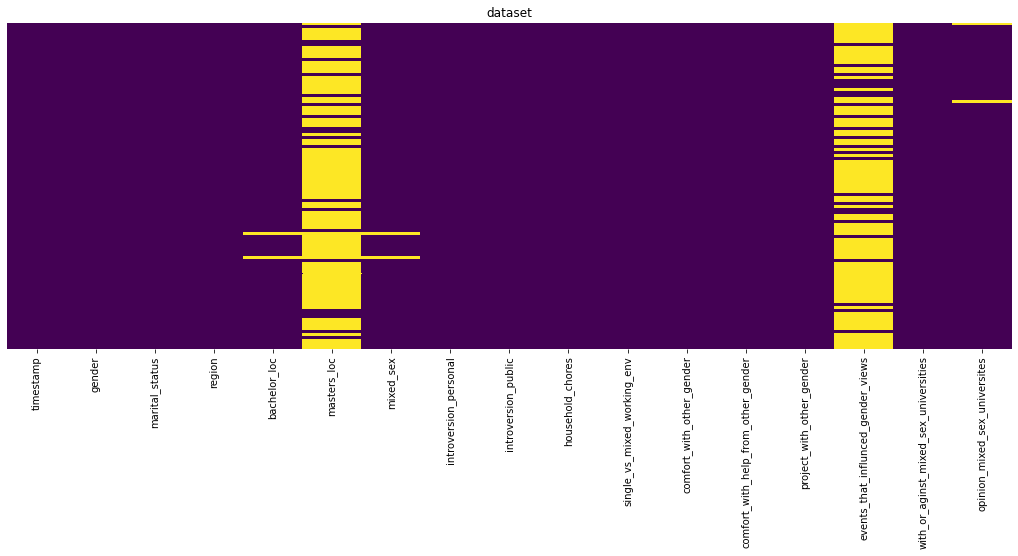

timestamp : % 0 With 0 missing values
gender : % 0 With 0 missing values
marital_status : % 0 With 0 missing values
region : % 0 With 0 missing values
bachelor_loc : % 1 With 2 missing values
masters_loc : % 80 With 88 missing values
mixed_sex : % 1 With 2 missing values
introversion_personal : % 0 With 0 missing values
introversion_public : % 0 With 0 missing values
household_chores : % 0 With 0 missing values
single_vs_mixed_working_env : % 0 With 0 missing values
comfort_with_other_gender : % 0 With 0 missing values
comfort_with_help_from_other_gender : % 0 With 0 missing values
project_with_other_gender : % 0 With 0 missing values
events_that_influnced_gender_views : % 77 With 84 missing values
with_or_aginst_mixed_sex_universities : % 0 With 0 missing values
opinion_mixed_sex_universites : % 1 With 2 missing values


In [15]:
# missing values
missing_heat_map(df)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 17 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   timestamp                              109 non-null    object
 1   gender                                 109 non-null    object
 2   marital_status                         109 non-null    object
 3   region                                 109 non-null    object
 4   bachelor_loc                           107 non-null    object
 5   masters_loc                            21 non-null     object
 6   mixed_sex                              107 non-null    object
 7   introversion_personal                  109 non-null    object
 8   introversion_public                    109 non-null    object
 9   household_chores                       109 non-null    object
 10  single_vs_mixed_working_env            109 non-null    object
 11  comfort_with_other_

## Timestamp

- Changed timestamp to Datetime format
- no missing values


In [17]:
#fixed to datetime format
df['timestamp'] = df['timestamp'].apply(lambda x: datetime.datetime.strptime(x.strip('+3'), '%Y/%m/%d %H:%M:%S %p %Z'))

In [18]:
df['timestamp']

0     2020-12-02 01:19:18
1     2020-12-02 01:21:06
2     2020-12-02 01:29:40
3     2020-12-02 01:31:00
4     2020-12-02 01:36:05
              ...        
104   2020-12-17 01:48:06
105   2020-12-17 01:50:29
106   2020-12-18 04:14:52
107   2020-12-20 04:14:56
108   2020-12-21 11:06:58
Name: timestamp, Length: 109, dtype: datetime64[ns]

## gender
**1) What is your gender?**
- No missing values
- two unique values (Male/Female)

In [19]:
df['gender'].isnull().sum()

0

In [20]:
df['gender'].value_counts()

Male      68
Female    41
Name: gender, dtype: int64

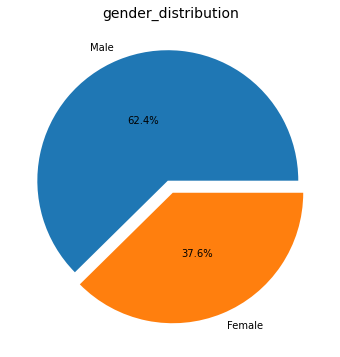

In [21]:
pie_chart('gender_distribution','gender_pie',df['gender'],2)

<AxesSubplot:xlabel='gender', ylabel='Count'>

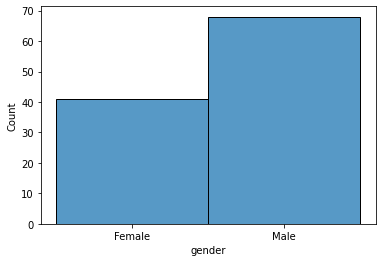

In [22]:
sns.histplot(df['gender'])

## marital_status
**2) What is your marital status?** 
- No null values
- Two uniqe values (Single/Married)


In [23]:
df['marital_status'].value_counts()

Single     101
Married      8
Name: marital_status, dtype: int64

In [24]:
df['marital_status'].isnull().sum()

0

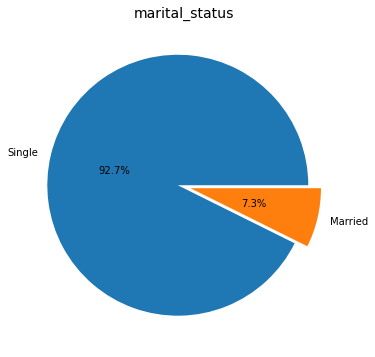

In [25]:
pie_chart('marital_status','marital_status_pie',df['marital_status'],2)

<AxesSubplot:xlabel='marital_status', ylabel='Count'>

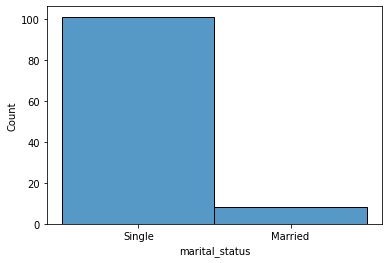

In [26]:
sns.histplot(df['marital_status'])

## region
**3) In which region are you located?**
- No missing values
- 4 unique values With most responds being in the centeral part of the region (%57.8)
- One missing region (South)

In [27]:
df['region'].isnull().sum()

0

In [28]:
df['region'].value_counts()

Center     63
Western    27
Eastern    18
Nothern     1
Name: region, dtype: int64

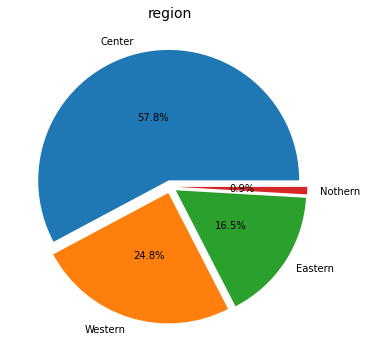

In [29]:
pie_chart('region','region_pie',df['region'],4)

<AxesSubplot:xlabel='region', ylabel='Count'>

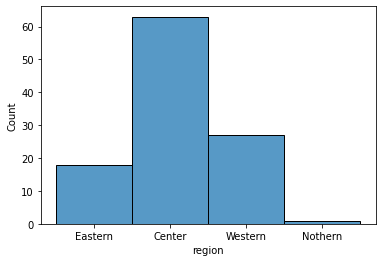

In [30]:
sns.histplot(df['region'])

## bachelor_loc
**4) Did you get your bachelor degree in Saudi or Abroad?**

- two missing values
- two uniqe values (Saudi/Abroad)


In [31]:
df['bachelor_loc'].isnull().sum()

2

In [32]:
df[df['bachelor_loc'].isnull()==True]

,timestamp,gender,marital_status,region,bachelor_loc,masters_loc,mixed_sex,introversion_personal,introversion_public,household_chores,single_vs_mixed_working_env,comfort_with_other_gender,comfort_with_help_from_other_gender,project_with_other_gender,events_that_influnced_gender_views,with_or_aginst_mixed_sex_universities,opinion_mixed_sex_universites
70,2020-12-06 05:02:25,Male,Single,Center,NaN,NaN,NaN,Inner reflection and solitude,Outgoing and talkative,2: Disagree,Single-sex work environment,3: Comfortable,3: Likely,3: Likely,NaN,Against mixed-sex universities,"Privacy, Competitiveness, Security"
78,2020-12-12 02:16:21,Male,Single,Center,NaN,NaN,NaN,Inner reflection and solitude,Outgoing and talkative,4: Strongly agree,Mixed-sex work environment,4: Very comfortable,4: Highly likely,4: Highly likely,NaN,With mixed-sex universities,"Open mind, ice breaks and better environment"


In [33]:
df['bachelor_loc'].value_counts()

Saudi     70
Abroad    37
Name: bachelor_loc, dtype: int64

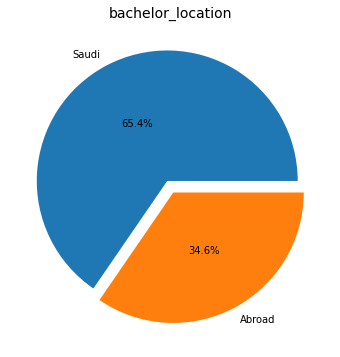

In [34]:
pie_chart('bachelor_location','bachelor_location_pie',df['bachelor_loc'],2)

In [35]:
df['bachelor_loc'].fillna('n/a',inplace=True)

<AxesSubplot:xlabel='bachelor_loc', ylabel='Count'>

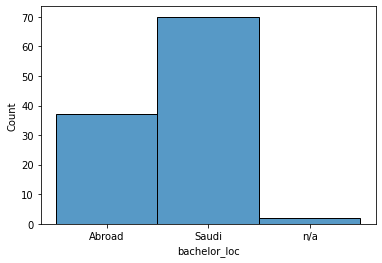

In [36]:
sns.histplot(df['bachelor_loc'])

## Masters_loc
**5) If you have a master's degree, did you study in Saudi or Abroad? If not applicable, please choose N/A**
- 88 missing values
- two uniqe values (Saudi/Abroad)

In [37]:
df['masters_loc'].isnull().sum()

88

In [38]:
df['masters_loc'].value_counts()

Abroad    15
Saudi      6
Name: masters_loc, dtype: int64

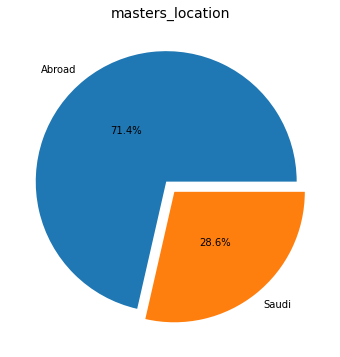

In [39]:
# Plot
pie_chart('masters_location','masters_location_pie',df['masters_loc'],2)

In [40]:
df['masters_loc'].fillna('n/a',inplace=True)

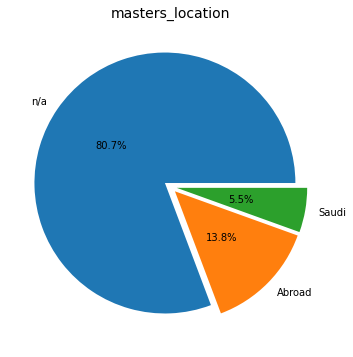

In [41]:
pie_chart('masters_location','masters_location_pie',df['masters_loc'],3)

<AxesSubplot:xlabel='masters_loc', ylabel='Count'>

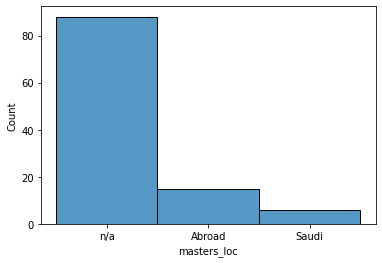

In [42]:
sns.histplot(df['masters_loc'])

## mixed_sex
**6) Have you ever studied in a mixed-sex university?**
- 2 missing values
- four possible choices

In [43]:
df['mixed_sex'].isnull().sum()

2

In [44]:
df[df['mixed_sex'].isnull()==True]


,timestamp,gender,marital_status,region,bachelor_loc,masters_loc,mixed_sex,introversion_personal,introversion_public,household_chores,single_vs_mixed_working_env,comfort_with_other_gender,comfort_with_help_from_other_gender,project_with_other_gender,events_that_influnced_gender_views,with_or_aginst_mixed_sex_universities,opinion_mixed_sex_universites
70,2020-12-06 05:02:25,Male,Single,Center,n/a,n/a,NaN,Inner reflection and solitude,Outgoing and talkative,2: Disagree,Single-sex work environment,3: Comfortable,3: Likely,3: Likely,NaN,Against mixed-sex universities,"Privacy, Competitiveness, Security"
78,2020-12-12 02:16:21,Male,Single,Center,n/a,n/a,NaN,Inner reflection and solitude,Outgoing and talkative,4: Strongly agree,Mixed-sex work environment,4: Very comfortable,4: Highly likely,4: Highly likely,NaN,With mixed-sex universities,"Open mind, ice breaks and better environment"


In [45]:
df['mixed_sex'].value_counts()

Yes, undergrad    55
No, neither       33
Yes, grad         10
Yes, both          9
Name: mixed_sex, dtype: int64

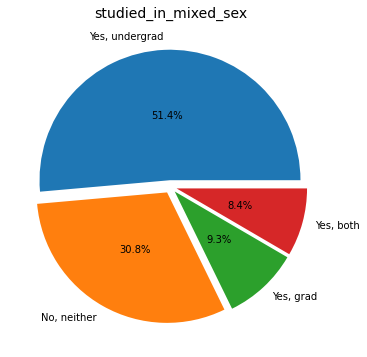

In [46]:
pie_chart('studied_in_mixed_sex','mixedsex_experince_pie',df['mixed_sex'],4)

In [47]:
df['mixed_sex'].fillna('n/a',inplace=True)

<AxesSubplot:xlabel='mixed_sex', ylabel='Count'>

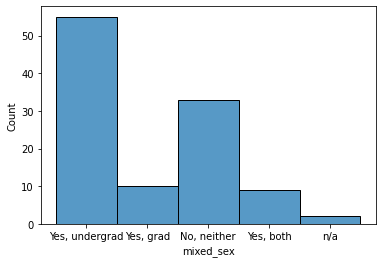

In [48]:
sns.histplot(df['mixed_sex'])

## introversion_personal
**7) After you spend a long day, how do you gain energy?**

- No missing values
- two unique values
- This will capture the persons perspetive on the level of introversion

In [49]:
df['introversion_personal'].value_counts()

Inner reflection and solitude    67
Going out with friends           42
Name: introversion_personal, dtype: int64

<AxesSubplot:xlabel='introversion_personal', ylabel='Count'>

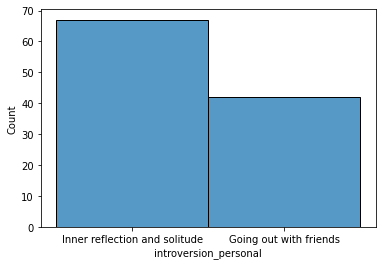

In [50]:
sns.histplot(df['introversion_personal'])

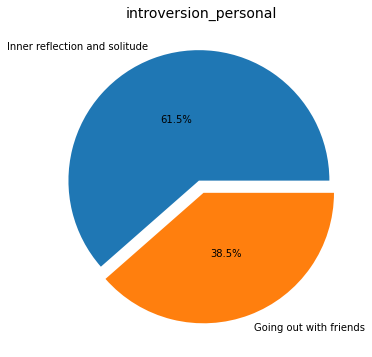

In [51]:
pie_chart('introversion_personal','introversion_personal_pie',df['introversion_personal'],2)

## introversion_public
**8) The people who know you best are more likely to describe you as someone who is:**
- No missing values
- two unique values 
- This will capture other peoples perspetive on the level of introversion 

In [52]:
df['introversion_public'].isnull().sum()

0

In [53]:
df['introversion_public'].value_counts()

Outgoing and talkative    66
Quiet and reflective      43
Name: introversion_public, dtype: int64

<AxesSubplot:xlabel='introversion_public', ylabel='Count'>

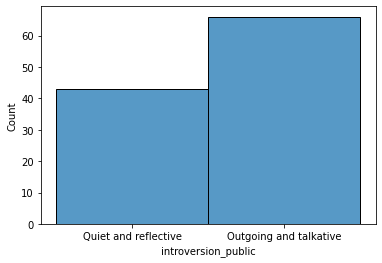

In [54]:
sns.histplot(df['introversion_public'])

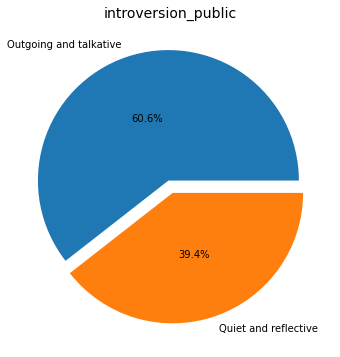

In [55]:
pie_chart('introversion_public','introversion_public_pie',df['introversion_public'],2)

## household_chores
**9) Do you think that household chores should be equally divided between men and women?**
- No missing values 
- four uniqe values (scale)

In [56]:
df['household_chores'].value_counts()

3: Agree                51
4: Strongly agree       36
2: Disagree             18
1: Strongly disagree     4
Name: household_chores, dtype: int64

In [57]:
df['household_chores'].isnull().sum()

0

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

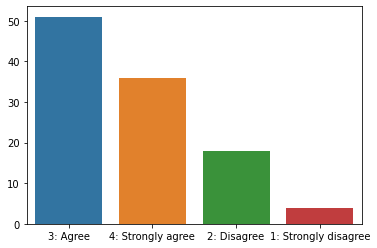

In [58]:
sns.barplot(df['household_chores'].value_counts().keys(),df['household_chores'].value_counts().values)

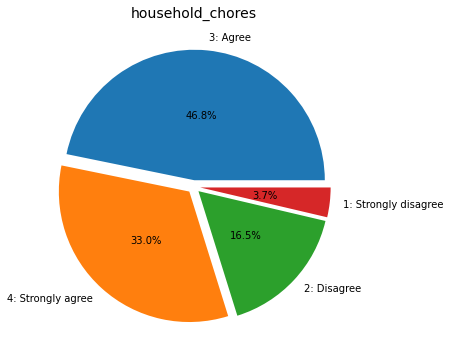

In [59]:
pie_chart('household_chores','household_chores_pie',df['household_chores'],4)

## single_vs_mixed_working_env
**10) Do you prefer working in a single-sex work environment or mixed-sex work environment?**
- No missing values 
- two uniqe values (scale)

In [60]:
df['single_vs_mixed_working_env'].value_counts()

Mixed-sex work environment     83
Single-sex work environment    26
Name: single_vs_mixed_working_env, dtype: int64

<AxesSubplot:xlabel='single_vs_mixed_working_env', ylabel='Count'>

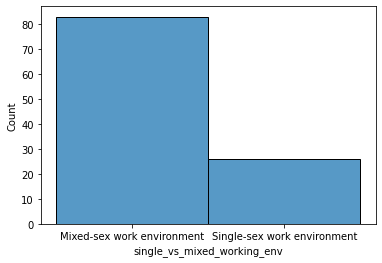

In [61]:
sns.histplot(df['single_vs_mixed_working_env'])

In [62]:
df['single_vs_mixed_working_env'].isnull().sum()

0

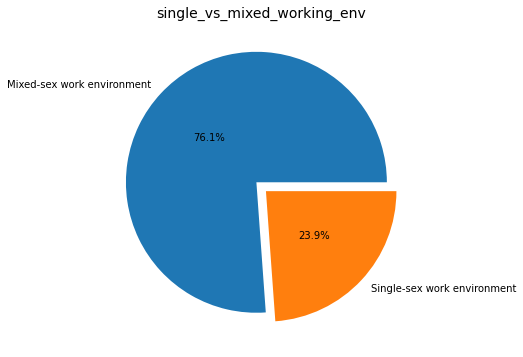

In [63]:
pie_chart('single_vs_mixed_working_env','single_vs_mixed_working_env_pie',df['single_vs_mixed_working_env'],2)

## comfort_with_other_gender
**11) In your previous work/internship experience: how comfortable did you feel talking to members of the opposite gender?**
- No missing values
- four unique values (scale)

In [64]:
df['comfort_with_other_gender'].value_counts()

3: Comfortable           47
4: Very comfortable      46
2: Uncomfortable         11
1: Very uncomfortable     5
Name: comfort_with_other_gender, dtype: int64

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

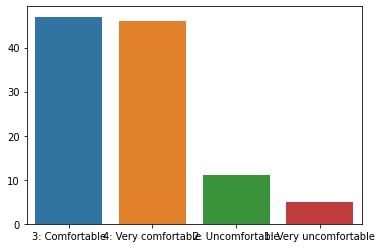

In [65]:
sns.barplot(df['comfort_with_other_gender'].value_counts().keys(),df['comfort_with_other_gender'].value_counts().values)

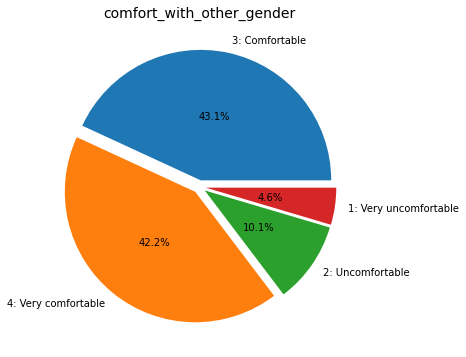

In [66]:
pie_chart('comfort_with_other_gender','comfort_with_other_gender_pie',df['comfort_with_other_gender'],4)

## comfort_with_help_from_other_gender
**12) If someone from the opposite gender has the information you need at work, how likely will you ask for the information?**
- No missing values
- four unique values (Scale)

In [67]:
df['comfort_with_help_from_other_gender'].value_counts()

4: Highly likely      81
3: Likely             22
2: Unlikely            5
1: Highly unlikely     1
Name: comfort_with_help_from_other_gender, dtype: int64

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

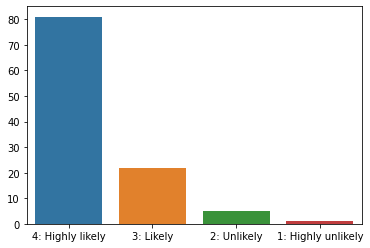

In [68]:
sns.barplot(df['comfort_with_help_from_other_gender'].value_counts().keys(),df['comfort_with_help_from_other_gender'].value_counts().values)

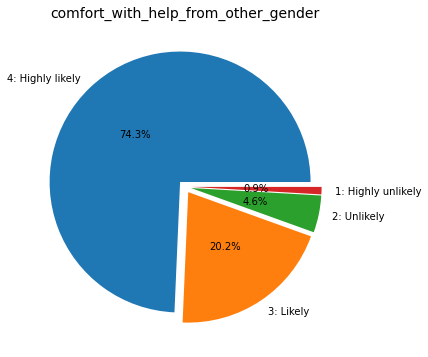

In [69]:
pie_chart('comfort_with_help_from_other_gender','comfort_with_help_from_other_gender_pie',df['comfort_with_help_from_other_gender'],4)

## project_with_other_gender
**13) How likely are you willing to work on a project with someone from the opposite gender?**
- No missing values
- four uniqe values (Scale)

In [70]:
df['project_with_other_gender'].isnull().sum()

0

In [71]:
df['project_with_other_gender'].value_counts()

4: Highly likely      74
3: Likely             24
2: Unlikely            8
1: Highly unlikely     3
Name: project_with_other_gender, dtype: int64

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

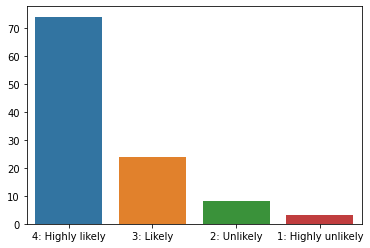

In [72]:
sns.barplot(df['project_with_other_gender'].value_counts().keys(),df['project_with_other_gender'].value_counts().values)

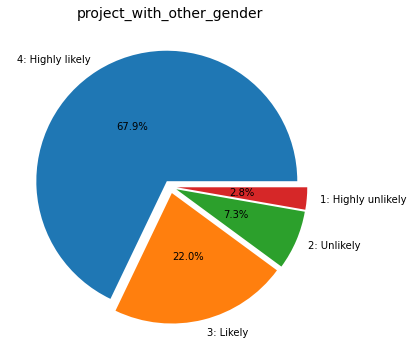

In [73]:
pie_chart('project_with_other_gender','project_with_other_gender_pie',df['project_with_other_gender'],4)

## events_that_influnced_gender_views
**14) If you studied abroad, can you identify any event that influenced your views about gender?**
- 89 missing values
- Text might quote from here


In [74]:
df['events_that_influnced_gender_views'].isnull().sum()

84

In [75]:
df['events_that_influnced_gender_views'].fillna('n/a',inplace=True)
df['events_that_influnced_gender_views'].replace([' ','?','.','Ok'],'n/a',inplace=True)

In [76]:
df['events_that_influnced_gender_views'].value_counts()

n/a                                                                                                                                                                                                                                                                                                                                                                                89
I grew up around brothers and cousins who were male, and went to summer camps almost every summer. So gender was never an issue for me.                                                                                                                                                                                                                                             1
Projects                                                                                                                                                                                                                                                    

## with_or_aginst_mixed_sex_universities
**15) Are you with or against mixed-sex universities in Saudi?**
- No missing values
- two possible unique values
- Dependant varible

In [77]:
df['with_or_aginst_mixed_sex_universities'].isnull().sum()

0

In [78]:
df['with_or_aginst_mixed_sex_universities'].value_counts()

With mixed-sex universities       74
Against mixed-sex universities    35
Name: with_or_aginst_mixed_sex_universities, dtype: int64

<AxesSubplot:xlabel='with_or_aginst_mixed_sex_universities', ylabel='Count'>

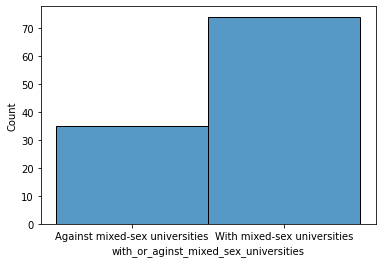

In [79]:
sns.histplot(df['with_or_aginst_mixed_sex_universities'])

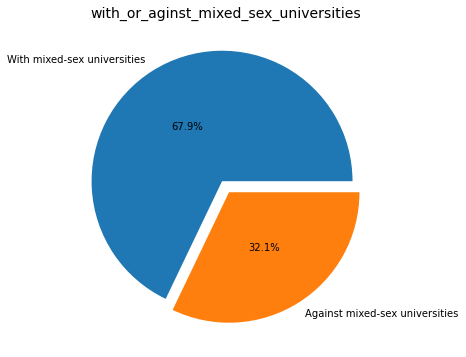

In [80]:
pie_chart('with_or_aginst_mixed_sex_universities','with_or_aginst_mixed_sex_universities_pie',df['with_or_aginst_mixed_sex_universities'],2)

In [81]:
# case study reasurch +1

## opinion_mixed_sex_universites
**16) What do you think about having mixed-sex universities in Saudi? Please list three reasons why or why not**
- two missing values
- text data

In [82]:
df['opinion_mixed_sex_universites'].isnull().sum()

2

In [83]:
df['opinion_mixed_sex_universites'].fillna('n/a',inplace=True)
df['opinion_mixed_sex_universites'].replace([' ','?','.','Ok'],'n/a',inplace=True)

In [84]:
df['opinion_mixed_sex_universites'].value_counts()

n/a                                                                                                                                                                                                                   5
Because everyone deserve an opportunity                                                                                                                                                                               3
It helps break the barrier that many end up facing in the workplace or if they travel. Mixing in a professional and decent manner shouldn’t be an issue.                                                              2
1) helps both genders learn how to communicate with eachother respectively 2) enhances networking 3) both genders can learn from eachother                                                                            2
create distractions, Not in line with the islamic rules                                                                                 

In [85]:
df['opinion_mixed_sex_universites'].value_counts()

n/a                                                                                                                                                                                                                   5
Because everyone deserve an opportunity                                                                                                                                                                               3
It helps break the barrier that many end up facing in the workplace or if they travel. Mixing in a professional and decent manner shouldn’t be an issue.                                                              2
1) helps both genders learn how to communicate with eachother respectively 2) enhances networking 3) both genders can learn from eachother                                                                            2
create distractions, Not in line with the islamic rules                                                                                 

In [86]:
#go over and quote

In [87]:
for i in df['opinion_mixed_sex_universites']:
    print(i)

n/a
Against it, privacy, competitiveness, security
Open mind, ice breaks and  better environment
1- it’s could be a problem in our society’s culture, 2- could create problems sexually, 3- could create issues with academic performance
I agree.
1. Preparing students for mixed-sex working places
2. Learning how to become comfortable with the other sex 
3. Getting used to the boadaries between both sexes. 
1- it would help our society shed their antiquated ideas about gender roles
2- prepares a new generation for the already unsegregated work environment
3- reducing the unnecessary costs of having two campuses 
Bring diversity, get them prepared for work culture, integration 
Mixed-sex can improve the quality of education 
Less cost 
Less resources
Great idea
Great
Great
I am only against It because of one reason. It is hard to stay in hijab all day especially the face cover. 
Both genders can understand eachother more
I think it’ll be good
It helps break the barrier that many end up facin

# Basic EDA

In [88]:
# create a copy of the dataframe to use for testing corrilation to understand and imporve feature engineering 
corr_df1 = df.copy()

In [89]:
# dataframe columns
corr_df1.columns

Index(['timestamp', 'gender', 'marital_status', 'region', 'bachelor_loc',
       'masters_loc', 'mixed_sex', 'introversion_personal',
       'introversion_public', 'household_chores',
       'single_vs_mixed_working_env', 'comfort_with_other_gender',
       'comfort_with_help_from_other_gender', 'project_with_other_gender',
       'events_that_influnced_gender_views',
       'with_or_aginst_mixed_sex_universities',
       'opinion_mixed_sex_universites'],
      dtype='object')

In [90]:
#select the features to drop because it will intoduce a huge number of features when dummied 
features = ['timestamp','events_that_influnced_gender_views','opinion_mixed_sex_universites']
select_features = [x for x in corr_df1.columns if x not in features] 
select_features 

['gender',
 'marital_status',
 'region',
 'bachelor_loc',
 'masters_loc',
 'mixed_sex',
 'introversion_personal',
 'introversion_public',
 'household_chores',
 'single_vs_mixed_working_env',
 'comfort_with_other_gender',
 'comfort_with_help_from_other_gender',
 'project_with_other_gender',
 'with_or_aginst_mixed_sex_universities']

In [91]:
# Create a test varible to test the corrilation with select features 
test = corr_df1[select_features] 
print(len(test))

109


In [92]:
test.head()

,gender,marital_status,region,bachelor_loc,masters_loc,mixed_sex,introversion_personal,introversion_public,household_chores,single_vs_mixed_working_env,comfort_with_other_gender,comfort_with_help_from_other_gender,project_with_other_gender,with_or_aginst_mixed_sex_universities
0,Female,Single,Eastern,Abroad,n/a,"Yes, undergrad",Inner reflection and solitude,Quiet and reflective,4: Strongly agree,Mixed-sex work environment,4: Very comfortable,4: Highly likely,4: Highly likely,Against mixed-sex universities
1,Male,Single,Center,Saudi,Abroad,"Yes, grad",Going out with friends,Outgoing and talkative,2: Disagree,Single-sex work environment,3: Comfortable,3: Likely,3: Likely,Against mixed-sex universities
2,Male,Single,Center,Saudi,n/a,"No, neither",Inner reflection and solitude,Outgoing and talkative,4: Strongly agree,Mixed-sex work environment,4: Very comfortable,4: Highly likely,4: Highly likely,With mixed-sex universities
3,Female,Single,Center,Saudi,n/a,"No, neither",Inner reflection and solitude,Outgoing and talkative,3: Agree,Single-sex work environment,3: Comfortable,4: Highly likely,3: Likely,Against mixed-sex universities
4,Female,Single,Eastern,Saudi,n/a,"No, neither",Going out with friends,Outgoing and talkative,4: Strongly agree,Mixed-sex work environment,3: Comfortable,4: Highly likely,4: Highly likely,With mixed-sex universities


In [93]:
#Converting the data into dummies to apply to check corrilations (test_dummies)
test_dummies = pd.get_dummies(test,drop_first=True)
test_dummies.head()

,gender_Male,marital_status_Single,region_Eastern,region_Nothern,region_Western,bachelor_loc_Saudi,bachelor_loc_n/a,masters_loc_Saudi,masters_loc_n/a,"mixed_sex_Yes, both",...,comfort_with_other_gender_2: Uncomfortable,comfort_with_other_gender_3: Comfortable,comfort_with_other_gender_4: Very comfortable,comfort_with_help_from_other_gender_2: Unlikely,comfort_with_help_from_other_gender_3: Likely,comfort_with_help_from_other_gender_4: Highly likely,project_with_other_gender_2: Unlikely,project_with_other_gender_3: Likely,project_with_other_gender_4: Highly likely,with_or_aginst_mixed_sex_universities_With mixed-sex universities
0,0,1,1,0,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,1,0
1,1,1,0,0,0,1,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
2,1,1,0,0,0,1,0,0,1,0,...,0,0,1,0,0,1,0,0,1,1
3,0,1,0,0,0,1,0,0,1,0,...,0,1,0,0,0,1,0,1,0,0
4,0,1,1,0,0,1,0,0,1,0,...,0,1,0,0,0,1,0,0,1,1


In [94]:
# The response distribution of the dependant varibe 
test['with_or_aginst_mixed_sex_universities'].value_counts()

With mixed-sex universities       74
Against mixed-sex universities    35
Name: with_or_aginst_mixed_sex_universities, dtype: int64

In [95]:
# The dependant varible after dummies
test_dummies['with_or_aginst_mixed_sex_universities_With mixed-sex universities'].value_counts()

1    74
0    35
Name: with_or_aginst_mixed_sex_universities_With mixed-sex universities, dtype: int64

In [96]:
# columns after dummies
test_dummies.columns

Index(['gender_Male', 'marital_status_Single', 'region_Eastern',
       'region_Nothern', 'region_Western', 'bachelor_loc_Saudi',
       'bachelor_loc_n/a', 'masters_loc_Saudi', 'masters_loc_n/a',
       'mixed_sex_Yes, both', 'mixed_sex_Yes, grad',
       'mixed_sex_Yes, undergrad', 'mixed_sex_n/a',
       'introversion_personal_Inner reflection and solitude',
       'introversion_public_Quiet and reflective',
       'household_chores_2: Disagree', 'household_chores_3: Agree',
       'household_chores_4: Strongly agree',
       'single_vs_mixed_working_env_Single-sex work environment',
       'comfort_with_other_gender_2: Uncomfortable',
       'comfort_with_other_gender_3: Comfortable',
       'comfort_with_other_gender_4: Very comfortable',
       'comfort_with_help_from_other_gender_2: Unlikely',
       'comfort_with_help_from_other_gender_3: Likely',
       'comfort_with_help_from_other_gender_4: Highly likely',
       'project_with_other_gender_2: Unlikely',
       'project_with_

#### Correrlation summary

#### **This correlation metrix is before scaleing the varibles in the feature engineering section. We can see that with our dependant varible dummied (with_or_aginst_mixed_sex_universities_With mixed-sex universities) will correlate with:**

- **single_vs_mixed_working_env_Single-sex work environment:** The largest negitive corrilation with the dependant varible by almost -.63

- **project_with_other_gender_4:Highly likely:** This varible has the second largest corrilation with our dependant varible with a positive .37 corrilation

- **comfort_with_help_from_other_gender_4: Highly likely:** There is a .32 positive corrilation with our dependant varible

- **household_chores_4: Strongly agree** There is a .27 positive corrilation with the dependant varible

#### On our first look we can see that there are some good corrilations that are seprated due to dummying the varibles. This will be fixed to understand a single virables contribution on the dependant varible

In [97]:
magnify_corr(test_dummies)

,gender_Male,marital_status_Single,region_Eastern,region_Nothern,region_Western,bachelor_loc_Saudi,bachelor_loc_n/a,masters_loc_Saudi,masters_loc_n/a,"mixed_sex_Yes, both","mixed_sex_Yes, grad","mixed_sex_Yes, undergrad",mixed_sex_n/a,introversion_personal_Inner reflection and solitude,introversion_public_Quiet and reflective,household_chores_2: Disagree,household_chores_3: Agree,household_chores_4: Strongly agree,single_vs_mixed_working_env_Single-sex work environment,comfort_with_other_gender_2: Uncomfortable,comfort_with_other_gender_3: Comfortable,comfort_with_other_gender_4: Very comfortable,comfort_with_help_from_other_gender_2: Unlikely,comfort_with_help_from_other_gender_3: Likely,comfort_with_help_from_other_gender_4: Highly likely,project_with_other_gender_2: Unlikely,project_with_other_gender_3: Likely,project_with_other_gender_4: Highly likely,with_or_aginst_mixed_sex_universities_With mixed-sex universities
gender_Male,1.00,0.22,-0.01,0.07,0.14,-0.30,0.11,-0.14,0.00,-0.11,-0.08,0.29,0.11,-0.19,-0.15,0.35,-0.03,-0.26,-0.14,-0.18,-0.17,0.32,-0.01,-0.22,0.24,0.00,-0.32,0.28,-0.05
marital_status_Single,0.22,1.00,-0.06,0.03,0.16,0.01,0.04,-0.09,-0.05,-0.17,0.09,0.00,0.04,-0.08,0.08,0.13,-0.16,0.12,-0.17,-0.02,0.03,0.03,-0.11,-0.03,0.16,-0.06,-0.02,0.11,0.03
region_Eastern,-0.01,-0.06,1.00,-0.04,-0.26,-0.18,-0.06,0.00,-0.03,-0.04,-0.06,0.09,-0.06,-0.21,0.05,-0.13,-0.07,0.11,-0.13,0.10,-0.14,-0.03,0.02,-0.10,0.04,-0.03,-0.06,0.04,0.04
region_Nothern,0.07,0.03,-0.04,1.00,-0.06,0.07,-0.01,-0.02,0.05,0.32,-0.03,-0.10,-0.01,0.08,-0.08,-0.04,-0.09,0.14,-0.05,-0.03,-0.08,0.11,-0.02,-0.05,0.06,-0.03,-0.05,0.07,0.07
region_Western,0.14,0.16,-0.26,-0.06,1.00,-0.15,-0.08,-0.14,0.12,-0.02,-0.11,0.06,-0.08,0.10,0.10,0.03,-0.07,0.05,-0.12,0.02,-0.03,0.07,-0.13,0.03,0.05,0.16,-0.10,0.03,-0.02
bachelor_loc_Saudi,-0.30,0.01,-0.18,0.07,-0.15,1.00,-0.18,0.10,0.02,-0.26,0.24,-0.40,-0.18,0.04,0.13,0.13,-0.18,0.08,0.24,0.12,0.15,-0.29,0.16,-0.01,-0.09,0.14,0.03,-0.14,-0.10
bachelor_loc_n/a,0.11,0.04,-0.06,-0.01,-0.08,-0.18,1.00,-0.03,0.07,-0.04,-0.04,-0.14,1.00,0.11,-0.11,0.12,-0.13,0.05,0.08,-0.05,0.02,0.02,-0.03,0.10,-0.08,-0.04,0.09,-0.05,-0.05
masters_loc_Saudi,-0.14,-0.09,0.00,-0.02,-0.14,0.10,-0.03,1.00,-0.49,0.07,-0.08,-0.24,-0.03,0.19,-0.03,-0.11,0.10,-0.08,0.15,-0.08,-0.05,-0.12,0.33,-0.02,-0.23,-0.07,0.07,-0.26,-0.18
masters_loc_n/a,0.00,-0.05,-0.03,0.05,0.12,0.02,0.07,-0.49,1.00,-0.28,-0.41,0.35,0.07,-0.05,0.01,0.03,-0.15,0.15,0.06,0.09,0.05,-0.01,-0.12,0.01,0.09,0.14,-0.19,0.21,0.01
"mixed_sex_Yes, both",-0.11,-0.17,-0.04,0.32,-0.02,-0.26,-0.04,0.07,-0.28,1.00,-0.10,-0.30,-0.04,0.10,-0.04,-0.13,0.12,0.00,-0.01,-0.10,0.01,0.08,-0.07,0.02,0.02,-0.08,0.08,-0.01,0.13


In [98]:
# get the top 10 correlated features with price
pos_top_features = top_corr_features('with_or_aginst_mixed_sex_universities_With mixed-sex universities',10,test_dummies)
for i in pos_top_features:
    print(i)

list of 10 best positive features based on pairwise correlation:
 ['with_or_aginst_mixed_sex_universities_With mixed-sex universities', 'project_with_other_gender_4: Highly likely', 'comfort_with_help_from_other_gender_4: Highly likely', 'household_chores_4: Strongly agree', 'comfort_with_other_gender_3: Comfortable', 'mixed_sex_Yes, undergrad', 'mixed_sex_Yes, both', 'introversion_public_Quiet and reflective', 'comfort_with_other_gender_4: Very comfortable', 'region_Nothern']
with_or_aginst_mixed_sex_universities_With mixed-sex universities
project_with_other_gender_4: Highly likely
comfort_with_help_from_other_gender_4: Highly likely
household_chores_4: Strongly agree
comfort_with_other_gender_3: Comfortable
mixed_sex_Yes, undergrad
mixed_sex_Yes, both
introversion_public_Quiet and reflective
comfort_with_other_gender_4: Very comfortable
region_Nothern


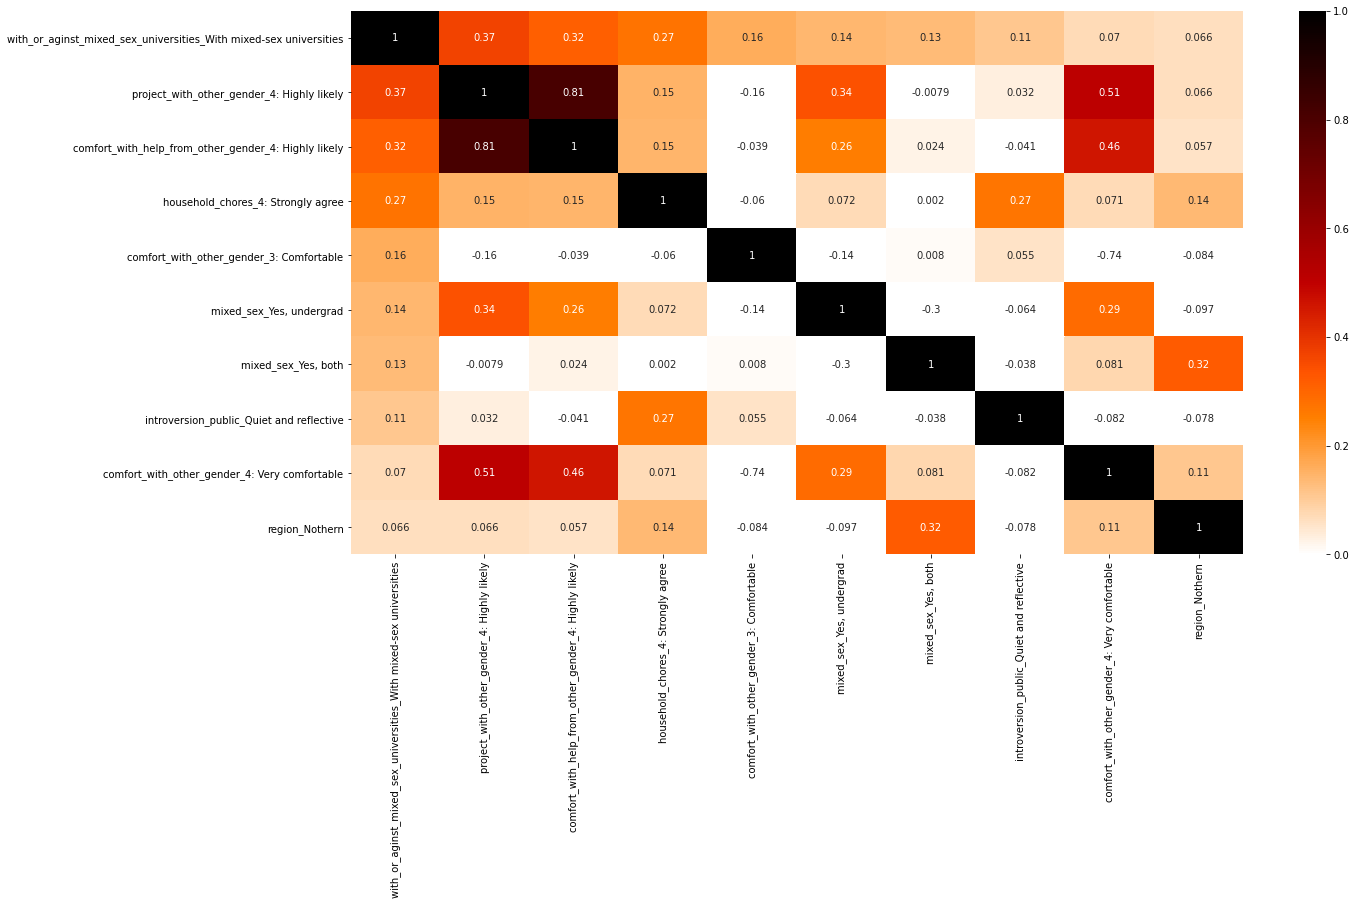

In [99]:
plot_corr(test_dummies[pos_top_features])

# Feature Extraction

In [100]:
# ADD Conservitive and radical

## <font color='red'>introversion(new_feature)</font>

Two inputs represent introversion. `introversion_personal` which indicates the person's perspective on the level of introversion and `introversion_public` which indicates people's perspective on the level of introversion.The two varibles were derived from:
- `introversion_personal` 

**Question** 7) After you spend a long day, how do you gain energy?

- `introversion_public`

**Question**8) The people who know you best are more likely to describe you as someone who is?

To get a better feature that will represent the overall level of introversion these features will be cross-checked creating a new variable called `introversion` which will serve as a better indicator

In [101]:
# This code will cross check the two features creating one feature as a result
introversion = []
for i in range(0,len(df)):
    if df['introversion_personal'][i]=='Going out with friends' and df['introversion_public'][i]=='Outgoing and talkative':
        introversion.append('extrovert')
    elif df['introversion_personal'][i]=='Inner reflection and solitude' and df['introversion_public'][i]=='Quiet and reflective':
        introversion.append('introvert')
    else:
        introversion.append('introvert/extrovert')
        
    
df['introversion'] = introversion

In [102]:
df[['introversion_personal','introversion_public','introversion']].head(5)

,introversion_personal,introversion_public,introversion
0,Inner reflection and solitude,Quiet and reflective,introvert
1,Going out with friends,Outgoing and talkative,extrovert
2,Inner reflection and solitude,Outgoing and talkative,introvert/extrovert
3,Inner reflection and solitude,Outgoing and talkative,introvert/extrovert
4,Going out with friends,Outgoing and talkative,extrovert


In [103]:
df['introversion'].head()

0              introvert
1              extrovert
2    introvert/extrovert
3    introvert/extrovert
4              extrovert
Name: introversion, dtype: object

In [104]:
df[['introversion','introversion_personal','introversion_public']].head(40)

,introversion,introversion_personal,introversion_public
0,introvert,Inner reflection and solitude,Quiet and reflective
1,extrovert,Going out with friends,Outgoing and talkative
2,introvert/extrovert,Inner reflection and solitude,Outgoing and talkative
3,introvert/extrovert,Inner reflection and solitude,Outgoing and talkative
4,extrovert,Going out with friends,Outgoing and talkative
5,introvert,Inner reflection and solitude,Quiet and reflective
6,introvert/extrovert,Inner reflection and solitude,Outgoing and talkative
7,extrovert,Going out with friends,Outgoing and talkative
8,extrovert,Going out with friends,Outgoing and talkative
9,extrovert,Going out with friends,Outgoing and talkative


In [105]:
df['introversion'].value_counts()

introvert/extrovert    52
introvert              29
extrovert              28
Name: introversion, dtype: int64

<AxesSubplot:xlabel='introversion', ylabel='Count'>

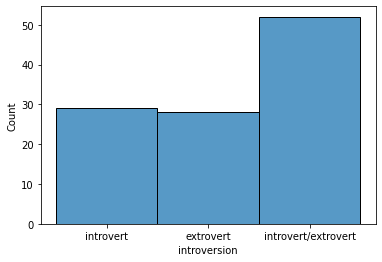

In [106]:
sns.histplot(df['introversion'])

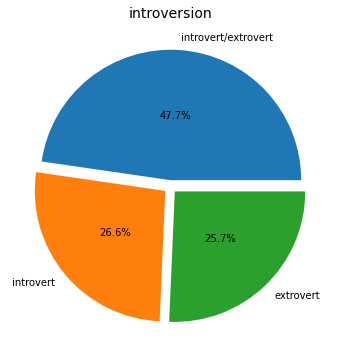

In [107]:
pie_chart('introversion','introversion_pie',df['introversion'],3)

In [108]:
df.columns

Index(['timestamp', 'gender', 'marital_status', 'region', 'bachelor_loc',
       'masters_loc', 'mixed_sex', 'introversion_personal',
       'introversion_public', 'household_chores',
       'single_vs_mixed_working_env', 'comfort_with_other_gender',
       'comfort_with_help_from_other_gender', 'project_with_other_gender',
       'events_that_influnced_gender_views',
       'with_or_aginst_mixed_sex_universities',
       'opinion_mixed_sex_universites', 'introversion'],
      dtype='object')

In [109]:

# Creating a hot encoder for the sake of checking the p-value
def change_format(x):
    if x == 'introvert':
        return int(0)
    elif x == 'extrovert':
        return int(1)
    elif x == 'introvert/extrovert':
        return int(2)

In [110]:
df['introversion_mapped'] = df['introversion'].apply(lambda x: change_format(x))

In [111]:
df['introversion_mapped'].value_counts()

2    52
0    29
1    28
Name: introversion_mapped, dtype: int64

## <font color='red'>exposure</font>

**Question** 6) Have you ever studied in a mixed-sex university?

`mixed_sex` will be given a weight that will be based on the number of years that are spent on education:-

According to most universities, a bachelors degree will take `four` years on average
According to most universities, a masters degree will take `two` years on average

Therefore one year will be weighted at `.16667` The new weighted feature will be called `mixed_sex_weighted`

In [112]:
'''
    Weight mapper for mixed sex:
    6) Have you ever studied in a mixed-sex university?
    
    This function takes answers from question 6 and gives weights to possible inputs:
    
    Yes, undergrad == .666 
    No, neither == 0    
    Yes, grad == .333       
    Yes, both == 1

'''
def mixed_sex_mapper(data_point):
    i = data_point
    year_weight = .16666666
    if i == 'Yes, both':
        return year_weight * 6
    elif i == 'Yes, undergrad':
        return year_weight * 4
    elif i == 'Yes, grad':
        return year_weight * 2
    else :
        return 0

In [113]:
df['exposure'] = df['mixed_sex'].apply(lambda x: mixed_sex_mapper(x))

In [114]:
df[['exposure','mixed_sex']].value_counts()

exposure  mixed_sex     
0.666667  Yes, undergrad    55
0.000000  No, neither       33
0.333333  Yes, grad         10
1.000000  Yes, both          9
0.000000  n/a                2
dtype: int64

In [115]:
df[['exposure','mixed_sex']].head(10)

,exposure,mixed_sex
0,0.666667,"Yes, undergrad"
1,0.333333,"Yes, grad"
2,0.000000,"No, neither"
3,0.000000,"No, neither"
4,0.000000,"No, neither"
5,0.000000,"No, neither"
6,0.333333,"Yes, grad"
7,0.333333,"Yes, grad"
8,0.000000,"No, neither"
9,0.666667,"Yes, undergrad"


## <font color='red'>household_chores_num</font>

**Question** 9) Do you think that household chores should be equally divided between men and women?

The feature `household_chores` is a scale ranging from 1 - 4: The string will be split to include only the number in an integer format. This will clearly show the full contribution of the variable on the dependent variable. The scaled feature will be called `household_chores_num`

In [116]:
df['household_chores'].value_counts()

3: Agree                51
4: Strongly agree       36
2: Disagree             18
1: Strongly disagree     4
Name: household_chores, dtype: int64

In [117]:
df['household_chores_num'] = df['household_chores'].apply(lambda x : int(x.split(':')[0]))

In [118]:
df[['household_chores_num','household_chores']].value_counts()

household_chores_num  household_chores    
3                     3: Agree                51
4                     4: Strongly agree       36
2                     2: Disagree             18
1                     1: Strongly disagree     4
dtype: int64

In [119]:
df[['household_chores_num','household_chores']].head(10)

,household_chores_num,household_chores
0,4,4: Strongly agree
1,2,2: Disagree
2,4,4: Strongly agree
3,3,3: Agree
4,4,4: Strongly agree
5,4,4: Strongly agree
6,3,3: Agree
7,2,2: Disagree
8,3,3: Agree
9,3,3: Agree


## <font color='red'>comfort_with_other_gender_num</font>

**Question** 11) In your previous work/internship experience: how comfortable did you feel talking to members of the opposite gender?

The feature `comfort_with_other_gender` is a scale ranging from 1 - 4: The string will be split to include only the number in an integer format. This will clearly show the full contribution of the variable on the dependent variable. The scaled feature will be called `comfort_with_other_gender_num`

In [120]:
df['comfort_with_other_gender'].value_counts()

3: Comfortable           47
4: Very comfortable      46
2: Uncomfortable         11
1: Very uncomfortable     5
Name: comfort_with_other_gender, dtype: int64

In [121]:
df['comfort_with_other_gender_num'] = df['comfort_with_other_gender'].apply(lambda x : int(x.split(':')[0]))

In [122]:
df[['comfort_with_other_gender_num','comfort_with_other_gender']].value_counts()

comfort_with_other_gender_num  comfort_with_other_gender
3                              3: Comfortable               47
4                              4: Very comfortable          46
2                              2: Uncomfortable             11
1                              1: Very uncomfortable         5
dtype: int64

In [123]:
df[['comfort_with_other_gender_num','comfort_with_other_gender']].head(10)

,comfort_with_other_gender_num,comfort_with_other_gender
0,4,4: Very comfortable
1,3,3: Comfortable
2,4,4: Very comfortable
3,3,3: Comfortable
4,3,3: Comfortable
5,4,4: Very comfortable
6,3,3: Comfortable
7,3,3: Comfortable
8,4,4: Very comfortable
9,3,3: Comfortable


## <font color='red'>comfort_with_help_from_other_gender_num</font>

**Question** 12) If someone from the opposite gender has the information you need at work, how likely will you ask for the information?

The feature `comfort_with_help_from_other_gender` is a scale ranging from 1 - 4: The string will be split to include only the number in an integer format. This will clearly show the full contribution of the variable on the dependent variable. The scaled feature will be called `comfort_with_help_from_other_gender_num`

In [124]:
df['comfort_with_help_from_other_gender'].value_counts()

4: Highly likely      81
3: Likely             22
2: Unlikely            5
1: Highly unlikely     1
Name: comfort_with_help_from_other_gender, dtype: int64

In [125]:
df['comfort_with_help_from_other_gender_num'] = df['comfort_with_help_from_other_gender'].apply(lambda x : int(x.split(':')[0]))

In [126]:
df[['comfort_with_help_from_other_gender_num','comfort_with_help_from_other_gender']]

,comfort_with_help_from_other_gender_num,comfort_with_help_from_other_gender
0,4,4: Highly likely
1,3,3: Likely
2,4,4: Highly likely
3,4,4: Highly likely
4,4,4: Highly likely
...,...,...
104,2,2: Unlikely
105,1,1: Highly unlikely
106,4,4: Highly likely
107,4,4: Highly likely


In [127]:
df.columns

Index(['timestamp', 'gender', 'marital_status', 'region', 'bachelor_loc',
       'masters_loc', 'mixed_sex', 'introversion_personal',
       'introversion_public', 'household_chores',
       'single_vs_mixed_working_env', 'comfort_with_other_gender',
       'comfort_with_help_from_other_gender', 'project_with_other_gender',
       'events_that_influnced_gender_views',
       'with_or_aginst_mixed_sex_universities',
       'opinion_mixed_sex_universites', 'introversion', 'introversion_mapped',
       'exposure', 'household_chores_num', 'comfort_with_other_gender_num',
       'comfort_with_help_from_other_gender_num'],
      dtype='object')

## <font color='red'>project_with_other_gender_num</font>

**Question** 13)How likely are you willing to work on a project with someone

The feature `project_with_other_gender` is a scale ranging from 1 - 4: The string will be split to include only the number in an integer format. This will clearly show the full contribution of the variable on the dependent variable. The scaled feature will be called `project_with_other_gender_num`

In [128]:
df['project_with_other_gender'].value_counts()

4: Highly likely      74
3: Likely             24
2: Unlikely            8
1: Highly unlikely     3
Name: project_with_other_gender, dtype: int64

In [129]:
df['project_with_other_gender_num'] = df['project_with_other_gender'].apply(lambda x : int(x.split(':')[0]))

In [130]:
df[['project_with_other_gender_num','project_with_other_gender']]

,project_with_other_gender_num,project_with_other_gender
0,4,4: Highly likely
1,3,3: Likely
2,4,4: Highly likely
3,3,3: Likely
4,4,4: Highly likely
...,...,...
104,2,2: Unlikely
105,1,1: Highly unlikely
106,4,4: Highly likely
107,4,4: Highly likely


## <font color='red'>level_of_comfort</font>

This column will measure the level of comfort determined using several independent variables:
The feature will be constructed using the sum of 3 scaled independent varibles varibles:-
- `project_with_other_gender_num` 
**Question** 13)How likely are you willing to work on a project with someone from the opposite gender?
- `comfort_with_help_from_other_gender_num` : 
**Question** 12) If someone from the opposite gender has the information you need at work, how likely will you ask for the information?
- `comfort_with_other_gender_num`
**Question** 11) In your previous work/internship experience: how comfortable did you feel talking to members of the opposite gender?

**The result will be a scale from 1-4 determining the comfort level for an individual with the opposite gender 4 being most comfortable and 0 most not comfortable.**

In [131]:
df['level_of_comfort']=df['project_with_other_gender_num']+df['comfort_with_help_from_other_gender_num']+df['comfort_with_other_gender_num']

In [132]:
df['level_of_comfort'].value_counts()

12    43
11    30
9     14
10     7
8      5
7      5
6      2
4      2
3      1
Name: level_of_comfort, dtype: int64

In [133]:
# Use a 4 point scale to scale the output
df['level_of_comfort'] = df['level_of_comfort'].apply(lambda x: x*.33333333333333333333)

In [134]:
df['level_of_comfort'].head(50)

0     4.000000
1     3.000000
2     4.000000
3     3.333333
4     3.666667
5     4.000000
6     3.333333
7     3.666667
8     4.000000
9     3.666667
10    3.000000
11    3.000000
12    3.333333
13    3.000000
14    4.000000
15    3.666667
16    3.666667
17    4.000000
18    2.333333
19    4.000000
20    4.000000
21    3.000000
22    4.000000
23    4.000000
24    4.000000
25    3.666667
26    3.666667
27    4.000000
28    4.000000
29    3.666667
30    4.000000
31    4.000000
32    4.000000
33    4.000000
34    4.000000
35    4.000000
36    3.000000
37    3.666667
38    2.666667
39    2.333333
40    4.000000
41    3.333333
42    2.333333
43    4.000000
44    3.666667
45    4.000000
46    3.000000
47    3.666667
48    3.666667
49    2.666667
Name: level_of_comfort, dtype: float64

## <font color='red'>Conservatism</font>

Conservatism will be a varible deducted from two varibles to determin the aversity to change. The two varibles are:-
- `household_chores_num` 
**Question** 9) Do you think that household chores should be equally divided between men and women?
- `single_vs_mixed_working_env` 
**Question** 10) Do you prefer working in a single-sex work environment or mixed-sex work environment? 

In [135]:
df['single_vs_mixed_working_env'].value_counts()

Mixed-sex work environment     83
Single-sex work environment    26
Name: single_vs_mixed_working_env, dtype: int64

In [136]:
df['household_chores_num'].head(5)

0    4
1    2
2    4
3    3
4    4
Name: household_chores_num, dtype: int64

In [137]:
def value_mapper(x):
    if x == 'Mixed-sex work environment':
        return int(3)
    elif x == 'Single-sex work environment':
        return int(1)

In [138]:
df['Conservatism'] = df['single_vs_mixed_working_env'].apply(lambda x : value_mapper(x)) * df['household_chores_num'] *.33333333333333333333

In [139]:
df[['Conservatism','single_vs_mixed_working_env','household_chores_num']]

,Conservatism,single_vs_mixed_working_env,household_chores_num
0,4.000000,Mixed-sex work environment,4
1,0.666667,Single-sex work environment,2
2,4.000000,Mixed-sex work environment,4
3,1.000000,Single-sex work environment,3
4,4.000000,Mixed-sex work environment,4
...,...,...,...
104,1.333333,Single-sex work environment,4
105,0.333333,Single-sex work environment,1
106,3.000000,Mixed-sex work environment,3
107,1.000000,Single-sex work environment,3


In [140]:
df['Conservatism'].value_counts()

3.000000    34
4.000000    34
1.000000    19
2.000000    13
0.666667     5
0.333333     2
1.333333     2
Name: Conservatism, dtype: int64

- Conservitive vs radical
- ((Find quantitative data source))

## Explatory Data Analysis

In [141]:
# grouped based on introversion
grouped_introversion=df[['introversion','gender','with_or_aginst_mixed_sex_universities']].groupby(['introversion','gender'])
grouped_introversion.count()

with_or_aginst_mixed_sex_universities
introversion        gender                                       
extrovert           Female                                      8
                    Male                                       20
introvert           Female                                     17
                    Male                                       12
introvert/extrovert Female                                     16
                    Male                                       36

In [142]:
np.unique(grouped_introversion.introversion.head().values)

array(['extrovert', 'introvert', 'introvert/extrovert'], dtype=object)

In [143]:
def plot_grouped_bar(dependent,grouped_dataframe,color='red'):

    """
    This function will plot the multi-index grouped varibles using a bar plot
    Arguments:
    dependent: takes the varible to measure from the grouped dataframe
    grouped_dataframe:Takes a grouped dataframe name without parentheses
    color: optional- choose the color of plots

 
    Returns:
    a plot for every dependent variable in the list
    """
    # The number of unique values that will be plotted
    
    dependent = str(dependent)
    
    x = len(np.unique(grouped_dataframe['{}'.format(dependent)].head().values))
    df = grouped_dataframe['{}'.format(dependent)].count()
    

    if x == 1:
        fig, ax = plt.subplots(1,1,figsize=(12, 12))
        #fig.tight_layout()
        plt.subplots_adjust
        
        df['{}'.format(np.unique(grouped_dataframe['{}'.format(dependent)].head().values)[0])]\
        .plot(kind='bar',ax=ax[0],title='{}'.format(np.unique(grouped_dataframe['{}'.format(dependent)].head().values)[0])\
              ,color=color)
        plt.show()


    elif x == 2:
        fig, ax = plt.subplots(2,1,figsize=(12, 12))
        #fig.tight_layout()
        plt.subplots_adjust
        
        df['{}'.format(np.unique(grouped_dataframe['{}'.format(dependent)].head().values)[0])]\
        .plot(kind='bar',ax=ax[0],title='{}'.format(np.unique(grouped_dataframe['{}'.format(dependent)].head().values)[0])\
              ,color=color)

        df['{}'.format(np.unique(grouped_dataframe['{}'.format(dependent)].head().values)[1])]\
        .plot(kind='bar',ax=ax[1],title='{}'.format(np.unique(grouped_dataframe['{}'.format(dependent)].head().values)[1])\
              ,color=color)
        plt.show()

    
    elif x == 3:
    
        fig, ax = plt.subplots(3,1,figsize=(12, 12))
        #fig.tight_layout()
        plt.subplots_adjust
        
        df['{}'.format(np.unique(grouped_dataframe['{}'.format(dependent)].head().values)[0])]\
        .plot(kind='bar',ax=ax[0],title='{}'.format(np.unique(grouped_dataframe['{}'.format(dependent)].head().values)[0])\
              ,color=color)

        df['{}'.format(np.unique(grouped_dataframe['{}'.format(dependent)].head().values)[1])]\
        .plot(kind='bar',ax=ax[1],title='{}'.format(np.unique(grouped_dataframe['{}'.format(dependent)].head().values)[1])\
              ,color=color)

        df['{}'.format(np.unique(grouped_dataframe['{}'.format(dependent)].head().values)[2])]\
        .plot(kind='bar',ax=ax[2],title='{}'.format(np.unique(grouped_dataframe['{}'.format(dependent)].head().values)[2])\
              ,color=color)
        plt.show()
        
    elif x == 4:
    
        fig, ax = plt.subplots(4,1,figsize=(12, 12))
        #fig.tight_layout()
        plt.subplots_adjust
    
        df['{}'.format(np.unique(grouped_dataframe['{}'.format(dependent)].head().values)[0])]\
        .plot(kind='bar',ax=ax[0],title='{}'.format(np.unique(grouped_dataframe['{}'.format(dependent)].head().values)[0])\
              ,color=color)

        df['{}'.format(np.unique(grouped_dataframe['{}'.format(dependent)].head().values)[1])]\
        .plot(kind='bar',ax=ax[1],title='{}'.format(np.unique(grouped_dataframe['{}'.format(dependent)].head().values)[1])\
              ,color=color)

        df['{}'.format(np.unique(grouped_dataframe['{}'.format(dependent)].head().values)[2])]\
        .plot(kind='bar',ax=ax[2],title='{}'.format(np.unique(grouped_dataframe['{}'.format(dependent)].head().values)[2])\
              ,color=color)
        
        df['{}'.format(np.unique(grouped_dataframe['{}'.format(dependent)].head().values)[3])]\
        .plot(kind='bar',ax=ax[3],title='{}'.format(np.unique(grouped_dataframe['{}'.format(dependent)].head().values)[3])\
              ,color=color)
        plt.show()

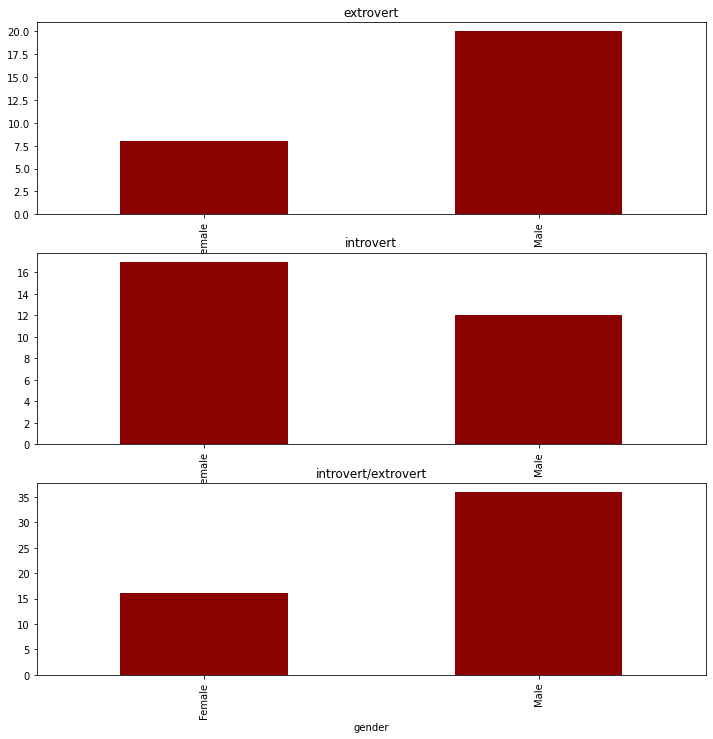

In [144]:
plot_grouped_bar('introversion',grouped_introversion,color='darkred')

In [145]:
# grouped based on introversion
grouped_gender=df[['introversion','gender','with_or_aginst_mixed_sex_universities']].groupby(['gender','introversion'])
grouped_gender.count()

with_or_aginst_mixed_sex_universities
gender introversion                                              
Female extrovert                                                8
       introvert                                               17
       introvert/extrovert                                     16
Male   extrovert                                               20
       introvert                                               12
       introvert/extrovert                                     36

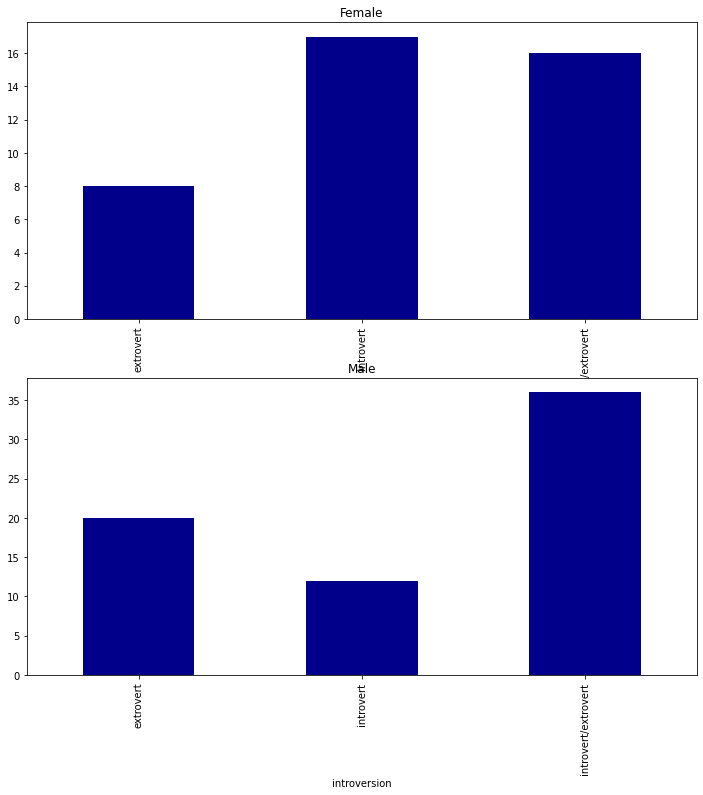

In [146]:
plot_grouped_bar('gender',grouped_gender,color='darkblue')

In [147]:
'male',sum(grouped_gender.count().values[[3,4,5]])[0] , 'female',sum(grouped_gender.count().values[[0,1,2]])[0]

('male', 68, 'female', 41)

In [148]:
grouped_dependent=df[['introversion','gender','with_or_aginst_mixed_sex_universities']].groupby(['with_or_aginst_mixed_sex_universities','gender'])
grouped_dependent.count()

introversion
with_or_aginst_mixed_sex_universities gender              
Against mixed-sex universities        Female            12
                                      Male              23
With mixed-sex universities           Female            29
                                      Male              45

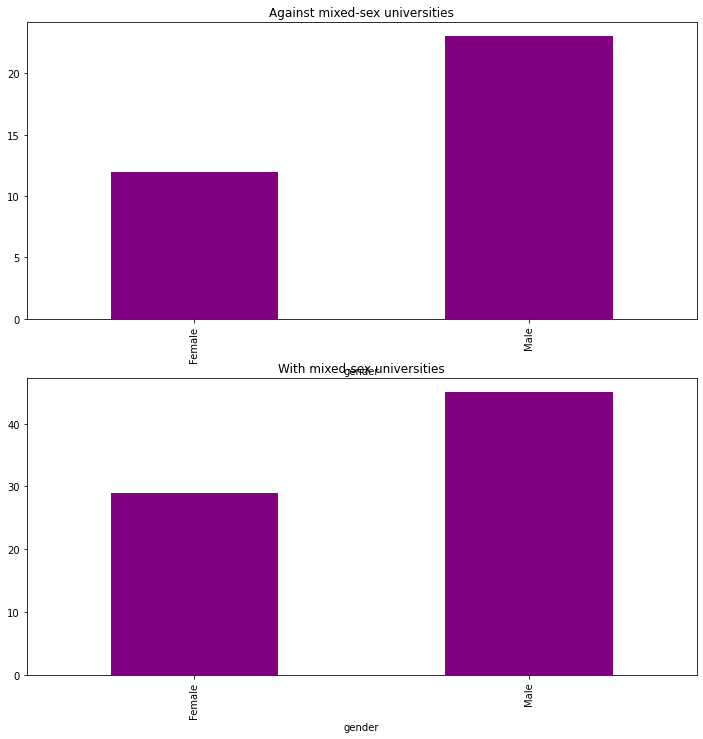

In [149]:
plot_grouped_bar('with_or_aginst_mixed_sex_universities',grouped_dependent,color='purple')

#### Weight/Scale
**mixed_sex_weighted**
- weight : 
           Yes, undergrad == .66  
           No, neither == 0    
           Yes, grad == .33       
           Yes, both == 1 )
         
**household_chores_num**
- scale :  
           4: Strongly agree 
           3: Agree                     
           2: Disagree             
           1: Strongly disagree

**comfort_with_other_gender**
- Scale :  
           4: Very comfortable     
           3: Comfortable           
           2: Uncomfortable         
           1: Very uncomfortable 
         
**comfort_with_help_from_other_gender_num**
- Scale :  
           4: Highly likely    
           3: Likely           
           2: Unlikely    
           1: Highly Unlikely
         
**project_with_other_gender_num**
- Scale :  
           4: Highly likely    
           3: Likely           
           2: Unlikely    
           1: Highly Unlikely
'''

In [150]:
df.groupby("gender").mean().T

gender,Female,Male
introversion_mapped,0.975610,1.352941
exposure,0.373984,0.495098
household_chores_num,3.439024,2.882353
comfort_with_other_gender_num,2.902439,3.426471
comfort_with_help_from_other_gender_num,3.512195,3.779412
project_with_other_gender_num,3.390244,3.647059
level_of_comfort,3.268293,3.617647
Conservatism,2.821138,2.558824


In [151]:
df.groupby("introversion").mean().T

introversion,extrovert,introvert,introvert/extrovert
introversion_mapped,1.000000,0.000000,2.000000
exposure,0.488095,0.379310,0.467949
household_chores_num,2.750000,3.172414,3.230769
comfort_with_other_gender_num,3.285714,3.034483,3.307692
comfort_with_help_from_other_gender_num,3.750000,3.551724,3.711538
project_with_other_gender_num,3.678571,3.448276,3.538462
level_of_comfort,3.571429,3.344828,3.519231
Conservatism,2.226190,2.804598,2.807692


# Model_preparation

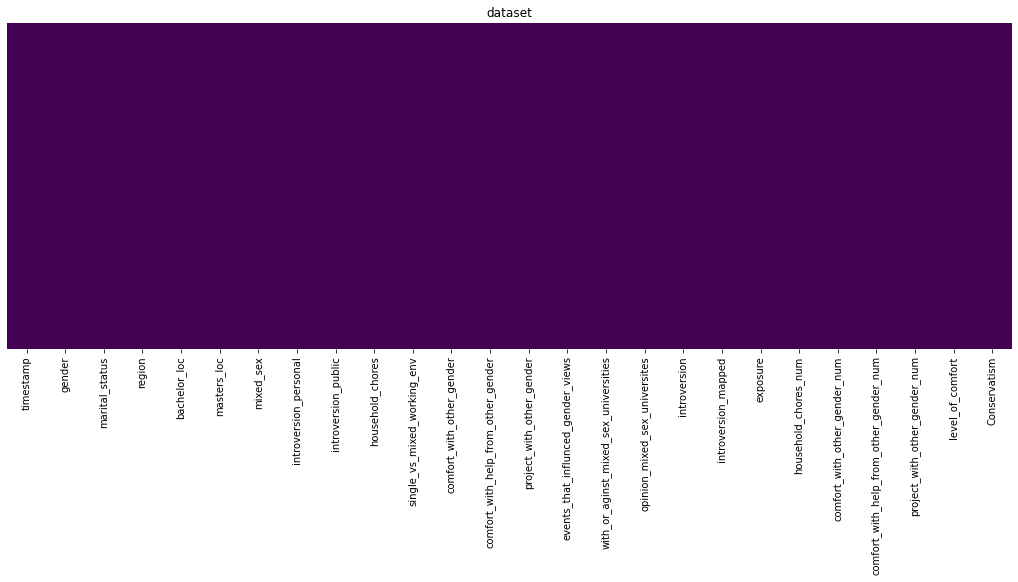

timestamp : % 0 With 0 missing values
gender : % 0 With 0 missing values
marital_status : % 0 With 0 missing values
region : % 0 With 0 missing values
bachelor_loc : % 0 With 0 missing values
masters_loc : % 0 With 0 missing values
mixed_sex : % 0 With 0 missing values
introversion_personal : % 0 With 0 missing values
introversion_public : % 0 With 0 missing values
household_chores : % 0 With 0 missing values
single_vs_mixed_working_env : % 0 With 0 missing values
comfort_with_other_gender : % 0 With 0 missing values
comfort_with_help_from_other_gender : % 0 With 0 missing values
project_with_other_gender : % 0 With 0 missing values
events_that_influnced_gender_views : % 0 With 0 missing values
with_or_aginst_mixed_sex_universities : % 0 With 0 missing values
opinion_mixed_sex_universites : % 0 With 0 missing values
introversion : % 0 With 0 missing values
introversion_mapped : % 0 With 0 missing values
exposure : % 0 With 0 missing values
household_chores_num : % 0 With 0 missing valu

In [152]:
# No missing values
missing_heat_map(df)

In [153]:
#columns
df.columns

Index(['timestamp', 'gender', 'marital_status', 'region', 'bachelor_loc',
       'masters_loc', 'mixed_sex', 'introversion_personal',
       'introversion_public', 'household_chores',
       'single_vs_mixed_working_env', 'comfort_with_other_gender',
       'comfort_with_help_from_other_gender', 'project_with_other_gender',
       'events_that_influnced_gender_views',
       'with_or_aginst_mixed_sex_universities',
       'opinion_mixed_sex_universites', 'introversion', 'introversion_mapped',
       'exposure', 'household_chores_num', 'comfort_with_other_gender_num',
       'comfort_with_help_from_other_gender_num',
       'project_with_other_gender_num', 'level_of_comfort', 'Conservatism'],
      dtype='object')

In [154]:
#make a copy for modeling 
mod_df = df.copy()

In [155]:
mod_df.columns

Index(['timestamp', 'gender', 'marital_status', 'region', 'bachelor_loc',
       'masters_loc', 'mixed_sex', 'introversion_personal',
       'introversion_public', 'household_chores',
       'single_vs_mixed_working_env', 'comfort_with_other_gender',
       'comfort_with_help_from_other_gender', 'project_with_other_gender',
       'events_that_influnced_gender_views',
       'with_or_aginst_mixed_sex_universities',
       'opinion_mixed_sex_universites', 'introversion', 'introversion_mapped',
       'exposure', 'household_chores_num', 'comfort_with_other_gender_num',
       'comfort_with_help_from_other_gender_num',
       'project_with_other_gender_num', 'level_of_comfort', 'Conservatism'],
      dtype='object')

**select the features to drop because it will intoduce a huge number of features when dummied 
or it has been replaced by a better representing feature**

In [156]:
mod_df.columns

Index(['timestamp', 'gender', 'marital_status', 'region', 'bachelor_loc',
       'masters_loc', 'mixed_sex', 'introversion_personal',
       'introversion_public', 'household_chores',
       'single_vs_mixed_working_env', 'comfort_with_other_gender',
       'comfort_with_help_from_other_gender', 'project_with_other_gender',
       'events_that_influnced_gender_views',
       'with_or_aginst_mixed_sex_universities',
       'opinion_mixed_sex_universites', 'introversion', 'introversion_mapped',
       'exposure', 'household_chores_num', 'comfort_with_other_gender_num',
       'comfort_with_help_from_other_gender_num',
       'project_with_other_gender_num', 'level_of_comfort', 'Conservatism'],
      dtype='object')

In [157]:
'''
features = ['opinion_mixed_sex_universites','events_that_influnced_gender_views',\
            'with_or_aginst_mixed_sex_universities','timestamp']
'''
#select the features to drop because it will intoduce a huge number of features when dummied
features = ['opinion_mixed_sex_universites','events_that_influnced_gender_views',\
            'with_or_aginst_mixed_sex_universities','timestamp',\
            'introversion_personal','introversion_public','household_chores','comfort_with_other_gender',\
            'comfort_with_help_from_other_gender','project_with_other_gender','bachelor_loc','masters_loc',\
            'single_vs_mixed_working_env','introversion','household_chores_num','comfort_with_other_gender_num',\
            'comfort_with_help_from_other_gender_num','project_with_other_gender_num','mixed_sex']     

select_features = [x for x in mod_df.columns if x not in features] 
select_features 

['gender',
 'marital_status',
 'region',
 'introversion_mapped',
 'exposure',
 'level_of_comfort',
 'Conservatism']

In [158]:
x = mod_df[select_features]
y = mod_df['with_or_aginst_mixed_sex_universities']
print(len(x),len(y))

109 109


In [159]:
#save pure csv with chosen features
data_pure_format = x.copy()

In [160]:
# include the dependant varible in the data set
data_pure_format['with_or_aginst_mixed_sex_universities'] = y

In [161]:
data_pure_format.columns

Index(['gender', 'marital_status', 'region', 'introversion_mapped', 'exposure',
       'level_of_comfort', 'Conservatism',
       'with_or_aginst_mixed_sex_universities'],
      dtype='object')

In [162]:
data_pure_format.to_csv('data_pure_format_chosen_features.csv')

In [163]:
data_pure_format

,gender,marital_status,region,introversion_mapped,exposure,level_of_comfort,Conservatism,with_or_aginst_mixed_sex_universities
0,Female,Single,Eastern,0,0.666667,4.000000,4.000000,Against mixed-sex universities
1,Male,Single,Center,1,0.333333,3.000000,0.666667,Against mixed-sex universities
2,Male,Single,Center,2,0.000000,4.000000,4.000000,With mixed-sex universities
3,Female,Single,Center,2,0.000000,3.333333,1.000000,Against mixed-sex universities
4,Female,Single,Eastern,1,0.000000,3.666667,4.000000,With mixed-sex universities
...,...,...,...,...,...,...,...,...
104,Female,Married,Eastern,1,0.000000,2.000000,1.333333,Against mixed-sex universities
105,Female,Married,Eastern,0,0.000000,1.000000,0.333333,Against mixed-sex universities
106,Male,Single,Eastern,1,0.666667,3.666667,3.000000,With mixed-sex universities
107,Male,Single,Center,1,0.666667,4.000000,1.000000,Against mixed-sex universities


In [164]:
x.head()

,gender,marital_status,region,introversion_mapped,exposure,level_of_comfort,Conservatism
0,Female,Single,Eastern,0,0.666667,4.000000,4.000000
1,Male,Single,Center,1,0.333333,3.000000,0.666667
2,Male,Single,Center,2,0.000000,4.000000,4.000000
3,Female,Single,Center,2,0.000000,3.333333,1.000000
4,Female,Single,Eastern,1,0.000000,3.666667,4.000000


In [165]:
y.head()

0    Against mixed-sex universities
1    Against mixed-sex universities
2       With mixed-sex universities
3    Against mixed-sex universities
4       With mixed-sex universities
Name: with_or_aginst_mixed_sex_universities, dtype: object

In [166]:
df.to_csv('full_dataset_all_features_not_dummied.csv')

### Dummies

In [167]:
x = pd.get_dummies(x,drop_first=True) #Converting the data into dummies to apply to models
x.head()

,introversion_mapped,exposure,level_of_comfort,Conservatism,gender_Male,marital_status_Single,region_Eastern,region_Nothern,region_Western
0,0,0.666667,4.000000,4.000000,0,1,1,0,0
1,1,0.333333,3.000000,0.666667,1,1,0,0,0
2,2,0.000000,4.000000,4.000000,1,1,0,0,0
3,2,0.000000,3.333333,1.000000,0,1,0,0,0
4,1,0.000000,3.666667,4.000000,0,1,1,0,0


In [168]:
# dummify the dependant varible 
y = pd.get_dummies(y,drop_first=True)
y.head()

,With mixed-sex universities
0,0
1,0
2,1
3,0
4,1


In [169]:
data_dummied_format = x.copy()

In [170]:
data_dummied_format['With mixed-sex universities'] = y

In [171]:
data_dummied_format.head()

,introversion_mapped,exposure,level_of_comfort,Conservatism,gender_Male,marital_status_Single,region_Eastern,region_Nothern,region_Western,With mixed-sex universities
0,0,0.666667,4.000000,4.000000,0,1,1,0,0,0
1,1,0.333333,3.000000,0.666667,1,1,0,0,0,0
2,2,0.000000,4.000000,4.000000,1,1,0,0,0,1
3,2,0.000000,3.333333,1.000000,0,1,0,0,0,0
4,1,0.000000,3.666667,4.000000,0,1,1,0,0,1


In [172]:
data_dummied_format.to_csv('data_dummied_format_chosen_features.csv')

In [173]:
df_corr = x.copy()

In [174]:
df_corr['With mixed-sex universities'] = y

In [175]:
df_corr.columns

Index(['introversion_mapped', 'exposure', 'level_of_comfort', 'Conservatism',
       'gender_Male', 'marital_status_Single', 'region_Eastern',
       'region_Nothern', 'region_Western', 'With mixed-sex universities'],
      dtype='object')

In [176]:
df['with_or_aginst_mixed_sex_universities'].value_counts()

With mixed-sex universities       74
Against mixed-sex universities    35
Name: with_or_aginst_mixed_sex_universities, dtype: int64

In [177]:
df_corr.columns

Index(['introversion_mapped', 'exposure', 'level_of_comfort', 'Conservatism',
       'gender_Male', 'marital_status_Single', 'region_Eastern',
       'region_Nothern', 'region_Western', 'With mixed-sex universities'],
      dtype='object')

In [178]:
sns.set(font_scale=2.5)

#### Correrlation summary

#### **This correlation metrix is after scaleing the varibles in the feature engineering section. We can see that with our dependant varible dummied (With mixed-sex universities) will correlate with:**

- **single_vs_mixed_working_env_Single-sex work environment:** The largest negitive corrilation with the dependant varible by almost -.63

- **project_with_other_gender_num:** This varible has the second largest corrilation with our dependant varible with a positive .43 corrilation

- **comfort_with_help_from_other_gender_num:** There is a .35 positive corrilation with our dependant varible

- **comfort_with_other_gender_num:** There is a .22 positive corrilation with the dependant varible

- **mixed_sex_weighted:** There is a .24 positive corrilation with the dependant varible

- **household_chores_num:** There is a . positive corrilation with the dependant varible

#### On our first look we can see that there are some good corrilations that are seprated due to dummying the varibles. This will be fixed to understand a single virables contribution on the dependant varible

In [179]:
magnify_corr(df_corr)

,introversion_mapped,exposure,level_of_comfort,Conservatism,gender_Male,marital_status_Single,region_Eastern,region_Nothern,region_Western,With mixed-sex universities
introversion_mapped,1.00,0.10,0.10,0.03,0.22,-0.01,-0.11,0.09,-0.02,-0.11
exposure,0.10,1.00,0.38,0.27,0.17,-0.11,0.04,0.16,0.01,0.24
level_of_comfort,0.10,0.38,1.00,0.32,0.26,0.18,-0.09,0.08,0.07,0.36
Conservatism,0.03,0.27,0.32,1.00,-0.11,0.16,0.12,0.11,0.09,0.51
gender_Male,0.22,0.17,0.26,-0.11,1.00,0.22,-0.01,0.07,0.14,-0.05
marital_status_Single,-0.01,-0.11,0.18,0.16,0.22,1.00,-0.06,0.03,0.16,0.03
region_Eastern,-0.11,0.04,-0.09,0.12,-0.01,-0.06,1.00,-0.04,-0.26,0.04
region_Nothern,0.09,0.16,0.08,0.11,0.07,0.03,-0.04,1.00,-0.06,0.07
region_Western,-0.02,0.01,0.07,0.09,0.14,0.16,-0.26,-0.06,1.00,-0.02
With mixed-sex universities,-0.11,0.24,0.36,0.51,-0.05,0.03,0.04,0.07,-0.02,1.00


In [180]:
# get the top 10 correlated features with dependent varible 
top_features = top_corr_features('With mixed-sex universities',10,df_corr)

list of 10 best positive features based on pairwise correlation:
 ['With mixed-sex universities', 'Conservatism', 'level_of_comfort', 'exposure', 'region_Nothern', 'region_Eastern', 'marital_status_Single', 'region_Western', 'gender_Male', 'introversion_mapped']


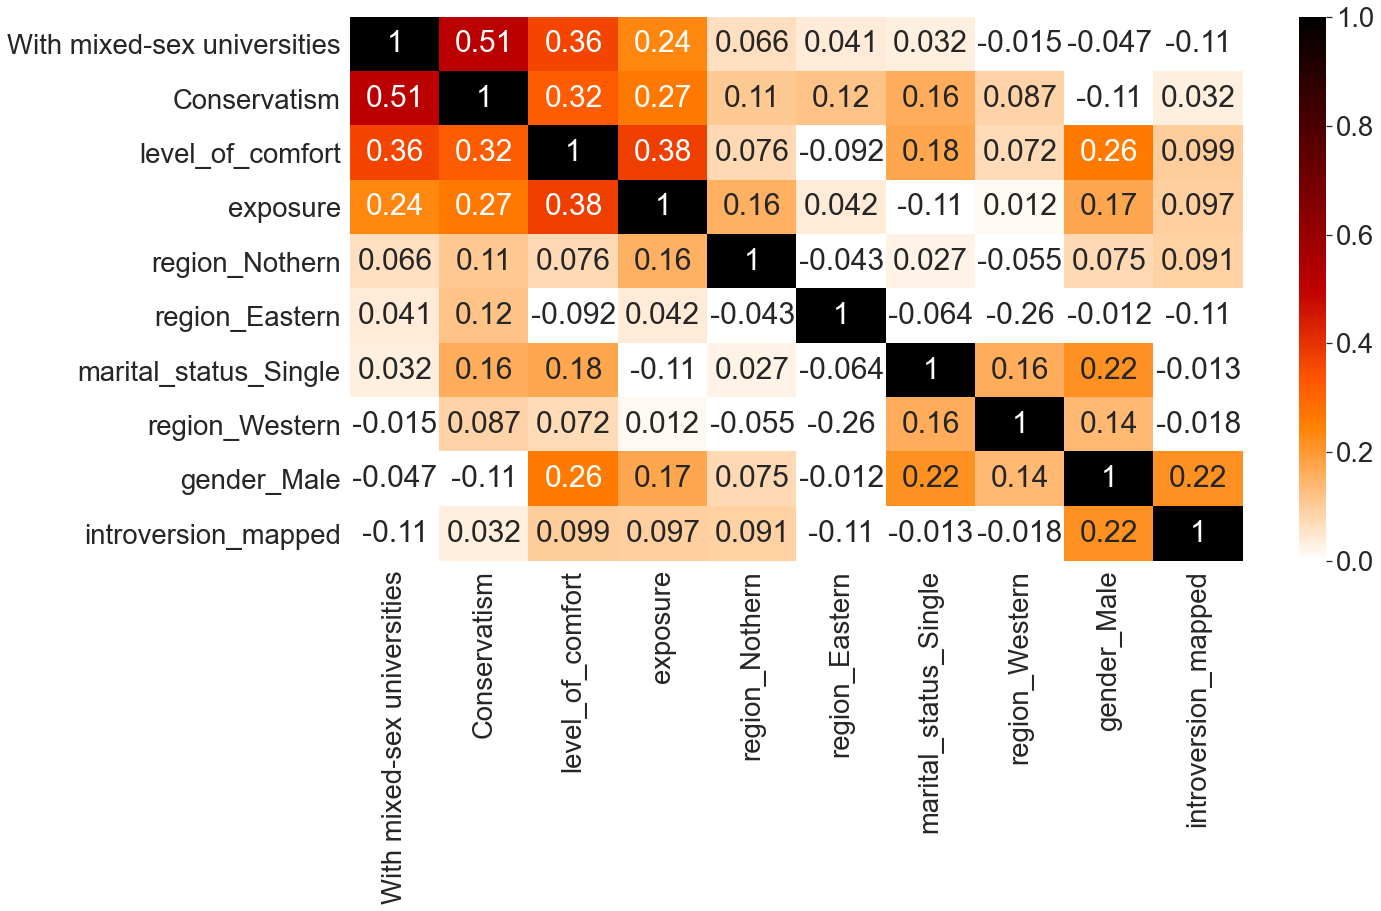

In [181]:
# Top positive corr
plot_corr(df_corr[top_features])

In [182]:
#scaled the x varible 
scaler = StandardScaler()
x_ss = scaler.fit_transform(x)

In [183]:
x.head()

,introversion_mapped,exposure,level_of_comfort,Conservatism,gender_Male,marital_status_Single,region_Eastern,region_Nothern,region_Western
0,0,0.666667,4.000000,4.000000,0,1,1,0,0
1,1,0.333333,3.000000,0.666667,1,1,0,0,0
2,2,0.000000,4.000000,4.000000,1,1,0,0,0
3,2,0.000000,3.333333,1.000000,0,1,0,0,0
4,1,0.000000,3.666667,4.000000,0,1,1,0,0


In [184]:
# split the train and test datasets for model evaluation (testing size 30% of the dataset)
x_train, x_test, y_train, y_test = train_test_split(x,y,stratify=y, test_size=0.3)

In [185]:
# The training dataset 76 inputs and the testing dataset is 33 inputs
len(y_train) , len(y_test)

(76, 33)

In [186]:
x_train.columns

Index(['introversion_mapped', 'exposure', 'level_of_comfort', 'Conservatism',
       'gender_Male', 'marital_status_Single', 'region_Eastern',
       'region_Nothern', 'region_Western'],
      dtype='object')

#### Logistic regression with stats model

In [187]:
log_reg = sm.Logit(y, x).fit(method='bfgs') 
print(log_reg.summary())

         Current function value: 0.058887
         Iterations: 1
         Function evaluations: 65
         Gradient evaluations: 53
                                Logit Regression Results                               
Dep. Variable:     With mixed-sex universities   No. Observations:                  109
Model:                                   Logit   Df Residuals:                      100
Method:                                    MLE   Df Model:                            8
Date:                         Mon, 11 Jan 2021   Pseudo R-squ.:                     inf
Time:                                 04:19:28   Log-Likelihood:                -6.4187
converged:                               False   LL-Null:                        0.0000
Covariance Type:                     nonrobust   LLR p-value:                     1.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:3489: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


# Modeling

#### logistic regression 

In [188]:
# initate the model and fit the model 
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
# Get the class predictions
print('Logreg predicted probabilities for x_test:\n', logreg.predict_proba(x_test))

Logreg predicted probabilities for x_test:
 [[0.08626937 0.91373063]
 [0.710351   0.289649  ]
 [0.04950703 0.95049297]
 [0.43488484 0.56511516]
 [0.06455526 0.93544474]
 [0.28865394 0.71134606]
 [0.21098826 0.78901174]
 [0.09607225 0.90392775]
 [0.14909292 0.85090708]
 [0.06747272 0.93252728]
 [0.18426673 0.81573327]
 [0.16596576 0.83403424]
 [0.57621587 0.42378413]
 [0.22343553 0.77656447]
 [0.1199388  0.8800612 ]
 [0.50883789 0.49116211]
 [0.28865394 0.71134606]
 [0.25735098 0.74264902]
 [0.21771685 0.78228315]
 [0.76742639 0.23257361]
 [0.0894716  0.9105284 ]
 [0.14245897 0.85754103]
 [0.65670351 0.34329649]
 [0.05582109 0.94417891]
 [0.20874591 0.79125409]
 [0.16545339 0.83454661]
 [0.20874591 0.79125409]
 [0.44083331 0.55916669]
 [0.20874591 0.79125409]
 [0.13677471 0.86322529]
 [0.05863302 0.94136698]
 [0.06289232 0.93710768]
 [0.66178945 0.33821055]]


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [189]:
# Predict the train and test dependant varible 
train_predicted = logreg.predict(x_train)
test_predicted = logreg.predict(x_test)
print('Logreg predicted labels:\n',test_predicted)

Logreg predicted labels:
 [1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0]


In [190]:
y_test.head(40)

,With mixed-sex universities
80,1
105,0
19,1
23,1
25,1
103,0
63,1
73,1
27,1
30,1


In [191]:
x_train.head()

,introversion_mapped,exposure,level_of_comfort,Conservatism,gender_Male,marital_status_Single,region_Eastern,region_Nothern,region_Western
36,2,0.000000,3.000000,1.0,0,1,0,0,0
21,2,0.666667,3.000000,3.0,1,1,0,0,0
29,2,0.666667,3.666667,1.0,1,1,0,0,0
87,1,0.000000,3.666667,1.0,0,1,0,0,0
82,2,0.666667,4.000000,4.0,1,1,1,0,0


In [192]:
#training size 
len(x_train['exposure'])

76

In [193]:
#testing size 
len(y_test['With mixed-sex universities'])

33

In [194]:
# Cross validated score for the training dataset (logistic)
cross_val_score(logreg,x_train,y_train,cv=5).mean()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A colu

0.79

In [195]:
# The cross validated score for the testing dataset (logistic)
cross_val_score(logreg,x_test,y_test,cv=5).mean()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A colu

0.9

- True Positive (TP): Outcome where the model correctly predicts the positive class.
- True Negative (TN): Outcome where the model correctly predicts the negative class.
- False Positive (FP): Also called a type 1 error, an outcome where the model incorrectly predicts the positive class when it is actually negative.
- False Negative (FN): Also called a type 2 error, an outcome where the model incorrectly predicts the negative class when it is actually positive.

In [196]:
# Training confusion matrix
print(len(train_predicted))
tn, fp, fn, tp = confusion_matrix(y_train, train_predicted).ravel()
('TrueNegitive : {}'.format(tn), 'FalsePositive : {}'.format(fp), 'FalseNegitive : {}'.format(fn), 'TruePositive : {}'.format(tp))

76


('TrueNegitive : 17',
 'FalsePositive : 7',
 'FalseNegitive : 5',
 'TruePositive : 47')

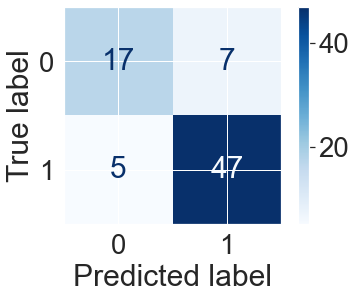

In [197]:
plot_confusion_matrix(logreg, x_train, y_train,cmap=plt.cm.Blues,)

In [198]:
print('accuracy : {}'.format(accuracy_score(y_train, train_predicted)))
# Recall
print('recall : {}'.format(recall_score(y_train, train_predicted)))
# Precision
print('precision : {}'.format(precision_score(y_train, train_predicted)))

accuracy : 0.8421052631578947
recall : 0.9038461538461539
precision : 0.8703703703703703


In [199]:
# Testing confustion matrix 
print(len(test_predicted))
tn, fp, fn, tp = confusion_matrix(y_test, test_predicted).ravel()
('TrueNegitive : {}'.format(tn), 'FalsePositive : {}'.format(fp), 'FalseNegitive : {}'.format(fn), 'TruePositive : {}'.format(tp))

33


('TrueNegitive : 5',
 'FalsePositive : 6',
 'FalseNegitive : 1',
 'TruePositive : 21')

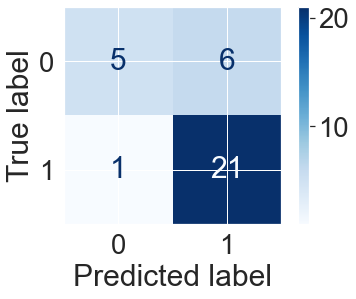

In [200]:
plot_confusion_matrix(logreg, x_test, y_test,cmap=plt.cm.Blues,)

In [201]:
print('accuracy : {}'.format(accuracy_score(y_test, test_predicted)))
# Recall
print('recall : {}'.format(recall_score(y_test, test_predicted)))
# Precision
print('precision : {}'.format(precision_score(y_test, test_predicted)))

accuracy : 0.7878787878787878
recall : 0.9545454545454546
precision : 0.7777777777777778


#### SVM

In [202]:
svm_classifier = svm.SVC(kernel='linear').fit(x_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [203]:
train_predicted = svm_classifier.predict(x_train)
test_predicted = svm_classifier.predict(x_test)

In [204]:
# Cross validated score for the training dataset (svm)
cross_val_score(svm_classifier,x_train,y_train,cv=5).mean()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A colu

0.8033333333333333

In [205]:
# Training confusion matrix (svm)
print(len(train_predicted))
tn, fp, fn, tp = confusion_matrix(y_train, train_predicted).ravel()
('TrueNegitive : {}'.format(tn), 'FalsePositive : {}'.format(fp), 'FalseNegitive : {}'.format(fn), 'TruePositive : {}'.format(tp))

76


('TrueNegitive : 17',
 'FalsePositive : 7',
 'FalseNegitive : 3',
 'TruePositive : 49')

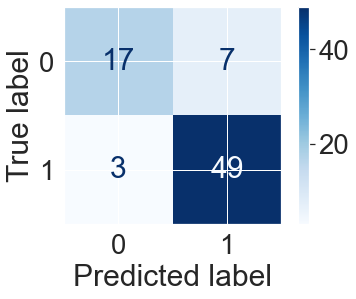

In [206]:
plot_confusion_matrix(svm_classifier, x_train, y_train,cmap=plt.cm.Blues)

In [207]:
# The cross validated score for the testing dataset (svm)
cross_val_score(svm_classifier,x_test,y_test,cv=5).mean()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A colu

0.9333333333333332

In [208]:
# testing confusion matrix (svm)
print(len(train_predicted))
tn, fp, fn, tp = confusion_matrix(y_test, test_predicted).ravel()
('TrueNegitive : {}'.format(tn), 'FalsePositive : {}'.format(fp), 'FalseNegitive : {}'.format(fn), 'TruePositive : {}'.format(tp))

76


('TrueNegitive : 5',
 'FalsePositive : 6',
 'FalseNegitive : 1',
 'TruePositive : 21')

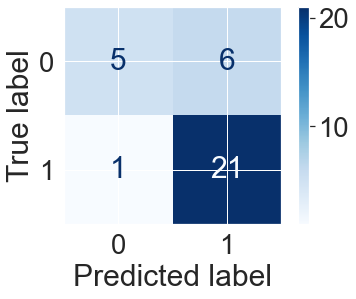

In [209]:
plot_confusion_matrix(svm_classifier, x_test, y_test,cmap=plt.cm.Blues)

In [210]:
x.to_csv('mod.csv')

In [211]:
df.head(50)

,timestamp,gender,marital_status,region,bachelor_loc,masters_loc,mixed_sex,introversion_personal,introversion_public,household_chores,...,opinion_mixed_sex_universites,introversion,introversion_mapped,exposure,household_chores_num,comfort_with_other_gender_num,comfort_with_help_from_other_gender_num,project_with_other_gender_num,level_of_comfort,Conservatism
0,2020-12-02 01:19:18,Female,Single,Eastern,Abroad,n/a,"Yes, undergrad",Inner reflection and solitude,Quiet and reflective,4: Strongly agree,...,n/a,introvert,0,0.666667,4,4,4,4,4.000000,4.000000
1,2020-12-02 01:21:06,Male,Single,Center,Saudi,Abroad,"Yes, grad",Going out with friends,Outgoing and talkative,2: Disagree,...,"Against it, privacy, competitiveness, security",extrovert,1,0.333333,2,3,3,3,3.000000,0.666667
2,2020-12-02 01:29:40,Male,Single,Center,Saudi,n/a,"No, neither",Inner reflection and solitude,Outgoing and talkative,4: Strongly agree,...,"Open mind, ice breaks and better environment",introvert/extrovert,2,0.000000,4,4,4,4,4.000000,4.000000
3,2020-12-02 01:31:00,Female,Single,Center,Saudi,n/a,"No, neither",Inner reflection and solitude,Outgoing and talkative,3: Agree,...,1- it’s could be a problem in our society’s cu...,introvert/extrovert,2,0.000000,3,3,4,3,3.333333,1.000000
4,2020-12-02 01:36:05,Female,Single,Eastern,Saudi,n/a,"No, neither",Going out with friends,Outgoing and talkative,4: Strongly agree,...,I agree.\n1. Preparing students for mixed-sex ...,extrovert,1,0.000000,4,3,4,4,3.666667,4.000000
5,2020-12-02 01:39:58,Male,Single,Western,Saudi,n/a,"No, neither",Inner reflection and solitude,Quiet and reflective,4: Strongly agree,...,1- it would help our society shed their antiqu...,introvert,0,0.000000,4,4,4,4,4.000000,4.000000
6,2020-12-02 01:42:53,Female,Single,Center,Saudi,Abroad,"Yes, grad",Inner reflection and solitude,Outgoing and talkative,3: Agree,...,"Bring diversity, get them prepared for work cu...",introvert/extrovert,2,0.333333,3,3,4,3,3.333333,3.000000
7,2020-12-02 01:50:41,Male,Single,Center,Saudi,Abroad,"Yes, grad",Going out with friends,Outgoing and talkative,2: Disagree,...,Mixed-sex can improve the quality of education,extrovert,1,0.333333,2,3,4,4,3.666667,2.000000
8,2020-12-02 01:55:01,Female,Single,Center,Saudi,n/a,"No, neither",Going out with friends,Outgoing and talkative,3: Agree,...,Less cost \nLess resources,extrovert,1,0.000000,3,4,4,4,4.000000,3.000000
9,2020-12-02 04:13:55,Male,Married,Center,Saudi,n/a,"Yes, undergrad",Going out with friends,Outgoing and talkative,3: Agree,...,Great idea,extrovert,1,0.666667,3,3,4,4,3.666667,3.000000


In [212]:
x.columns

Index(['introversion_mapped', 'exposure', 'level_of_comfort', 'Conservatism',
       'gender_Male', 'marital_status_Single', 'region_Eastern',
       'region_Nothern', 'region_Western'],
      dtype='object')